In [1]:
import os
import sys
import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd

# Switch to parent path to import local module
parent_path = str(os.getcwd()).split('notebooks')[0] # zeosyn_gen
os.chdir(parent_path)
print('Switched directory to:', os.getcwd())

import torch
import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from eval import load_model, get_prediction_and_ground_truths, eval_zeolite_aggregated, eval_zeolite_osda, plot_single_system
from data.metrics import maximum_mean_discrepancy, wasserstein_distance
from models.diffusion import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from matplotlib.colors import LogNorm

from sklearn.neighbors import KernelDensity

plt.rc('font', family='Helvetica')

Switched directory to: /home/jupyter/Elton/Zeolites/zeosyn_gen


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
with open(f'data/ZeoSynGen_dataset.pkl', 'rb') as f: # load dataset
    dataset = pickle.load(f)
data = dataset.get_datapoints_by_index(dataset_idxs=range(len(dataset)), scaled=False, return_dataframe=True)
zeo, osda = data[3], data[13]
df = pd.DataFrame({'zeo': zeo, 'osda': osda})
df[df['zeo']=='KFI']['osda'].unique()

array(['C1COCCOCCOCCOCCOCCO1', 'C[N+](C)(C)C', 'OSDA-free'], dtype=object)

In [3]:
zeo, osda = 'CHA', 'C[N+](C)(C)C12CC3CC(CC(C3)C1)C2'

In [4]:
model_type = 'diff'
fname = 'v3'
split = 'system'

# Load configs
with open(f'runs/{model_type}/{split}/{fname}/configs.json') as f:
    configs = json.load(f)
with open(f"runs/{model_type}/{split}/{fname}/train_loss_list.pkl", 'rb') as f: # load dataset
    train_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/val_loss_list.pkl", 'rb') as f: # load dataset
    val_loss_list = pickle.load(f)

model, configs = load_model(model_type, fname, split)
syn_pred, syn_pred_scaled, syn_true, syn_true_scaled, dataset = get_prediction_and_ground_truths(model, configs, cond_scale=0.75, split='test')

Loading model and configs...
Getting model predictions and grouth truths...
SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Loading synthetic predictions from saved predictions...


CHA C[N+](C)(C)C12CC3CC(CC(C3)C1)C2


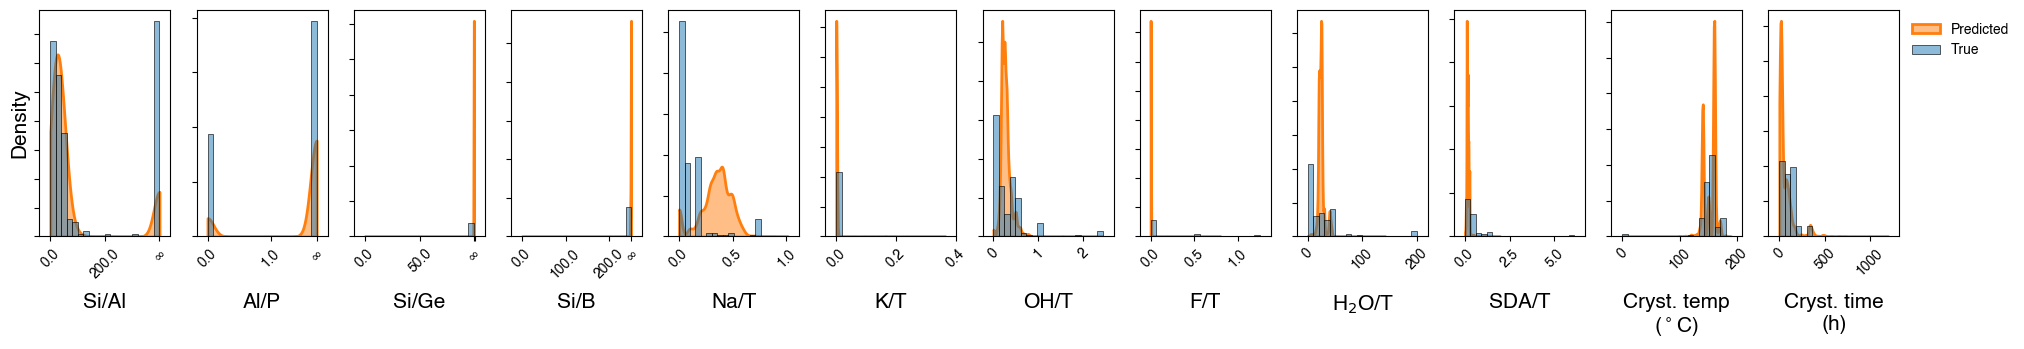

In [5]:
plot_single_system(syn_pred, syn_true, zeo=zeo, osda=osda)

In [6]:
pred, true = syn_pred[(syn_pred['zeo'] == zeo) & (syn_pred['osda'] == osda)], syn_true[(syn_true['zeo'] == zeo) & (syn_true['osda'] == osda)]

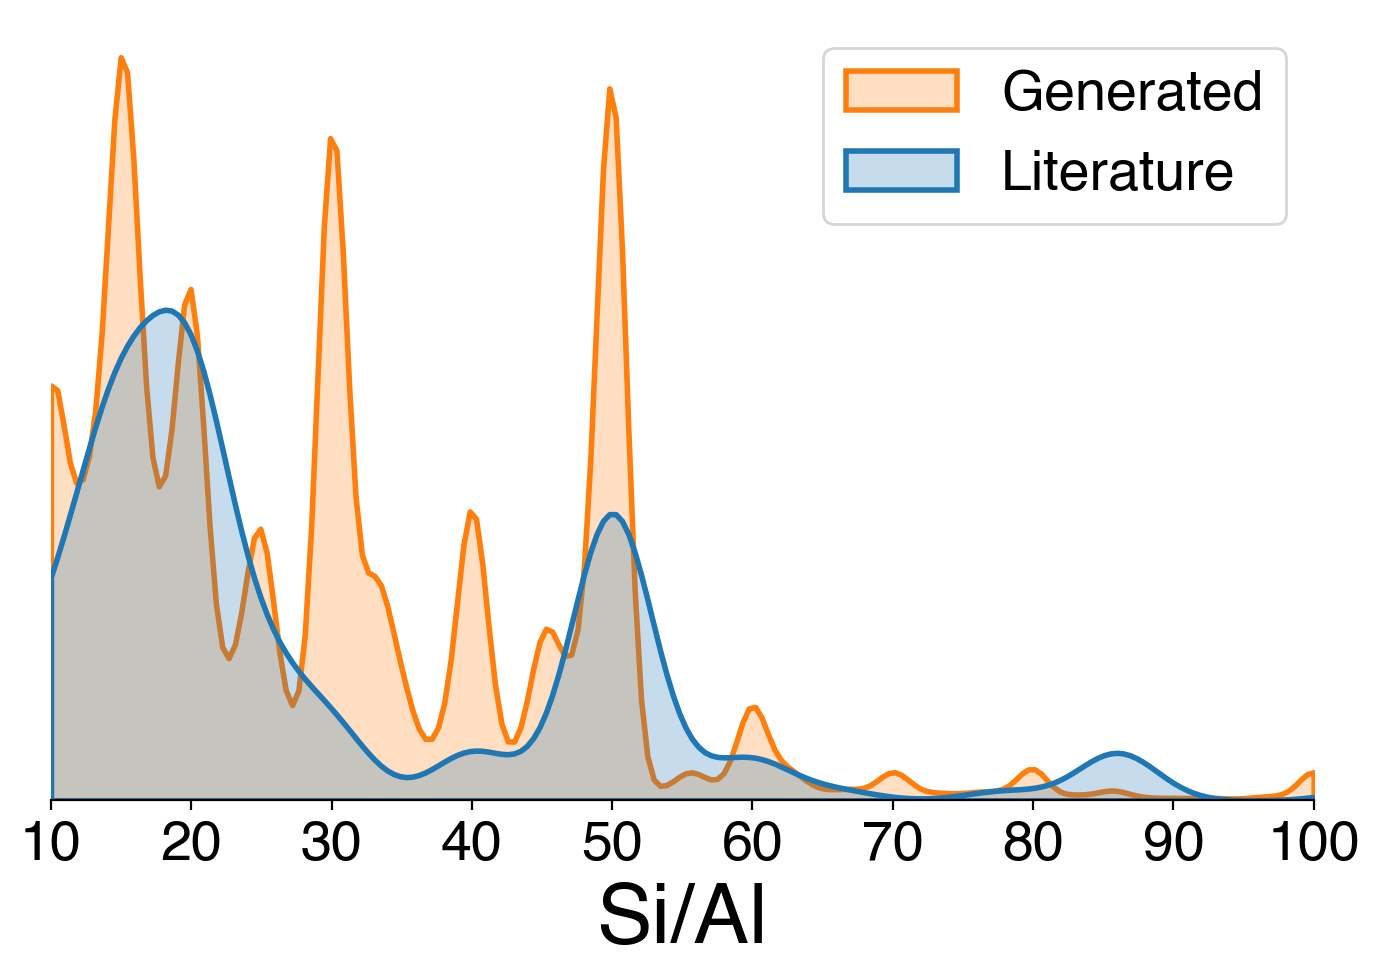

In [7]:
fig = plt.figure(figsize=(7, 5), dpi=200)

# Add subplots
xlim = (10, 100)
sns.kdeplot(pred['Si/Al'], label='Generated', fill=True, bw_adjust=0.05, color='tab:orange', clip=xlim, cut=100, linewidth=2)
# sns.histplot(true['Si/Al'], label='Literature', bins=50, binrange=xlim, stat='density')
sns.kdeplot(true['Si/Al'], label='Literature', fill=True, bw_adjust=0.05, color='tab:blue',  clip=xlim, cut=100, linewidth=2)
plt.legend(loc='upper right', fontsize=20, frameon=True)
plt.xlim(*xlim)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Si/Al', fontsize=30)
plt.ylabel('Density', fontsize=30)
ax = plt.gca()
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

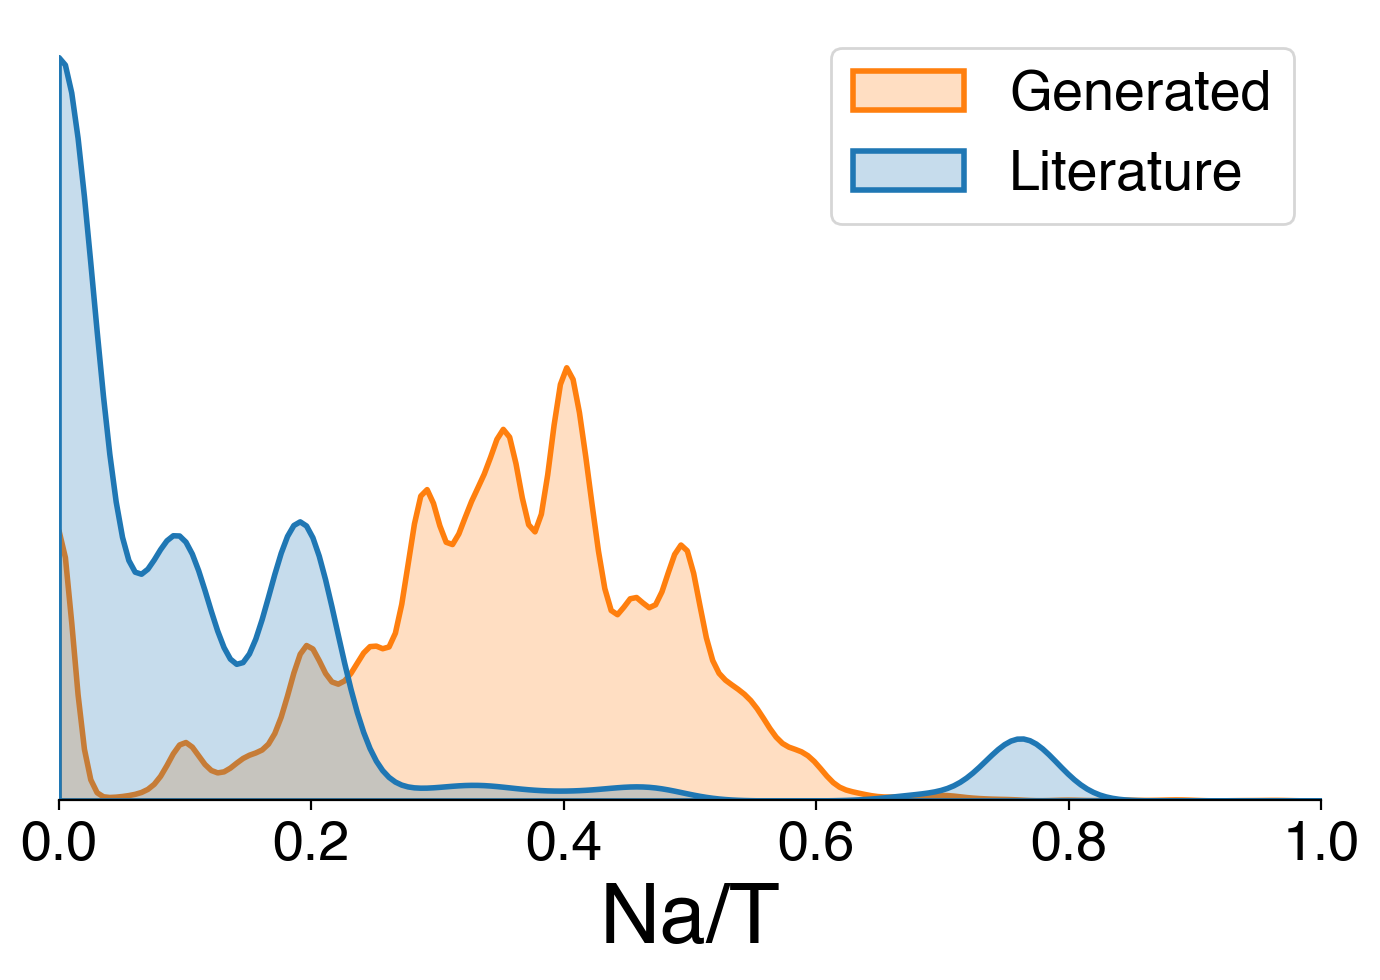

In [8]:
fig = plt.figure(figsize=(7, 5), dpi=200)

# Add subplots
xlim = (0, 1.)
sns.kdeplot(pred['Na/T'], label='Generated', fill=True, bw_adjust=0.5, color='tab:orange', clip=xlim, cut=100, linewidth=2)
# sns.histplot(true['Si/Al'], label='Literature', bins=50, binrange=xlim, stat='density')
sns.kdeplot(true['Na/T'], label='Literature', fill=True, bw_adjust=0.5, color='tab:blue',  clip=xlim, cut=100, linewidth=2)
plt.legend(loc='upper right', fontsize=20, frameon=True)
plt.xlim(*xlim)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Na/T', fontsize=30)
plt.ylabel('Density', fontsize=30)
ax = plt.gca()
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

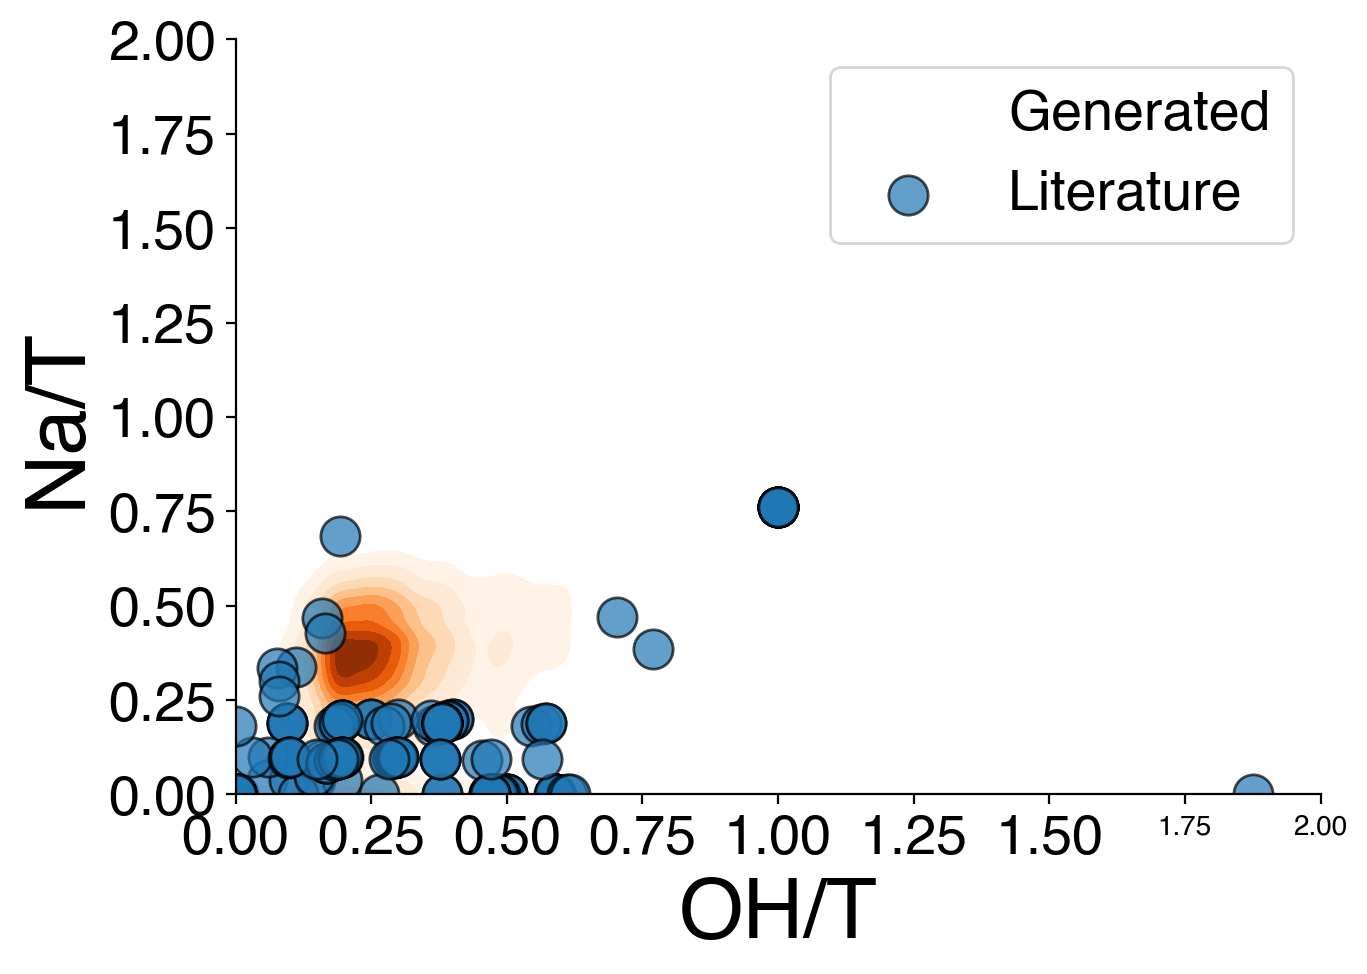

In [9]:
xlim = (0., 2.0)
ylim = (0., 2.0)

fig = plt.figure(figsize=(7, 5), dpi=200)
sns.kdeplot(data=pred, x='OH/T', y='Na/T', fill=True, cmap='Oranges', alpha=1, label='Generated', bw_adjust=1.0, clip=(xlim, ylim))
plt.scatter(true['OH/T'], true['Na/T'], color='tab:blue', s=200, alpha=0.7, marker='o', edgecolor='black', label='Literature')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('OH/T', fontsize=30)
plt.ylabel('Na/T', fontsize=30)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.legend(loc='upper right', fontsize=20, frameon=True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

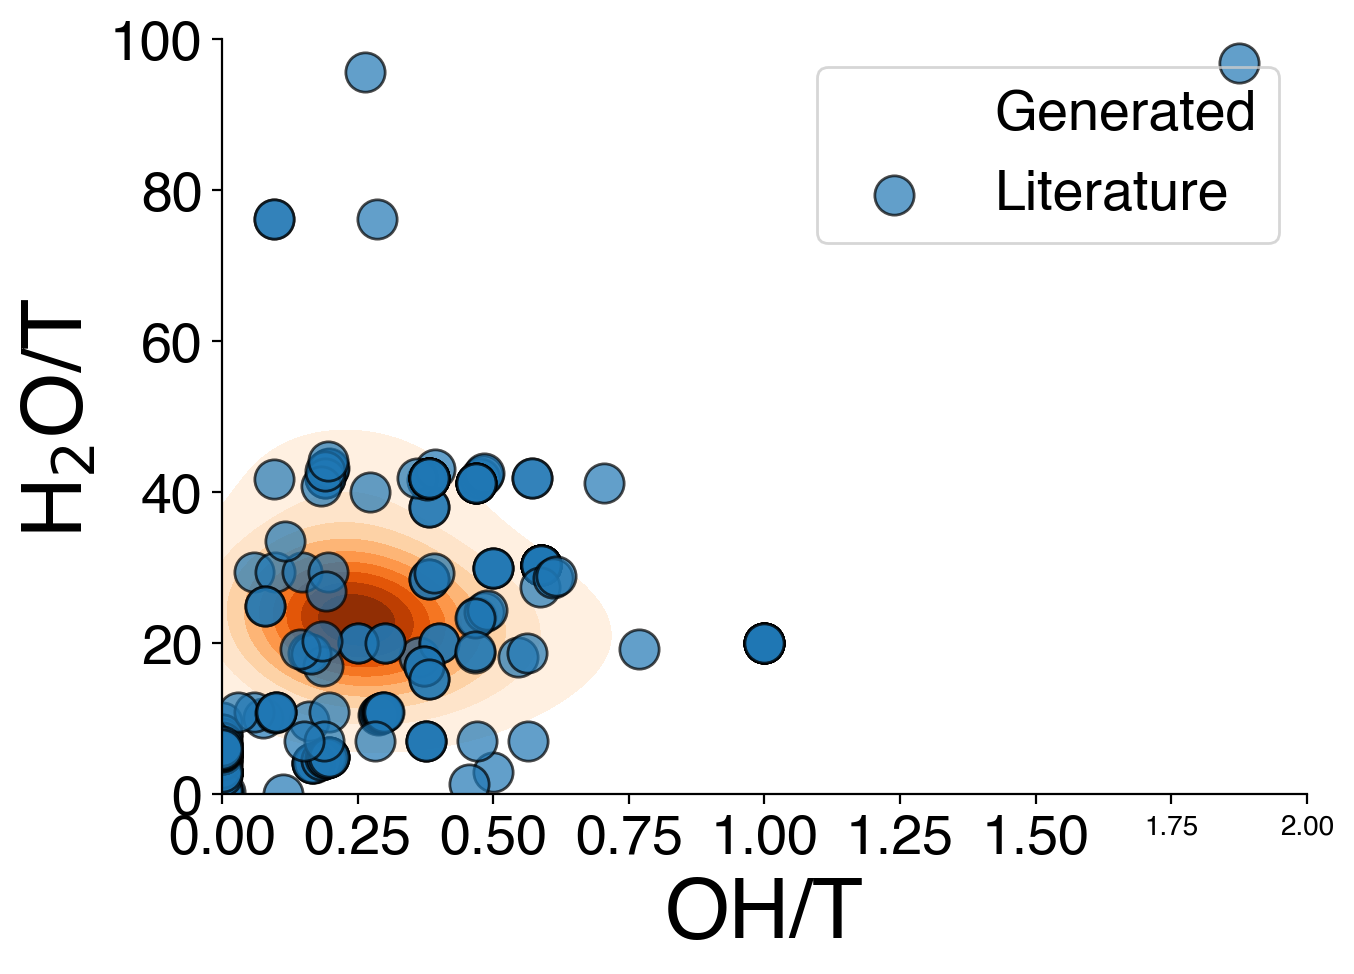

In [10]:
xlim = (0., 2.0)
ylim = (0., 100)

fig = plt.figure(figsize=(7, 5), dpi=200)
sns.kdeplot(data=pred, x='OH/T', y='H2O/T', fill=True, cmap='Oranges', alpha=1, label='Generated', bw_adjust=5.0, clip=(xlim, ylim))
plt.scatter(true['OH/T'], true['H2O/T'], color='tab:blue', s=200, alpha=0.7, marker='o', edgecolor='black', label='Literature')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('OH/T', fontsize=30)
plt.ylabel('H$_2$O/T', fontsize=30)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.legend(loc='upper right', fontsize=20, frameon=True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

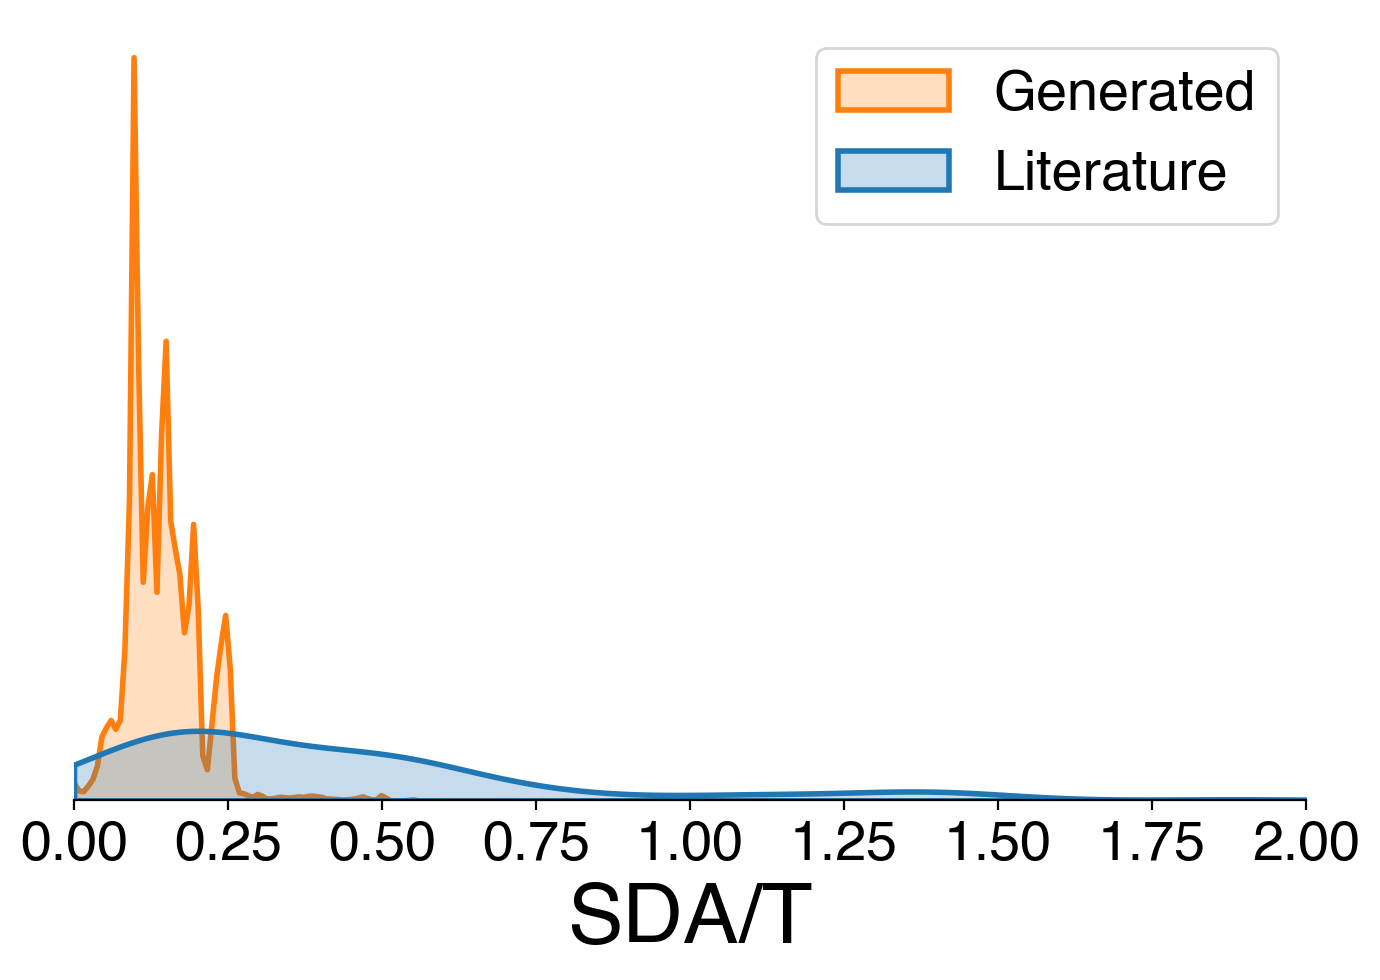

In [11]:
fig = plt.figure(figsize=(7, 5), dpi=200)

# Add subplots
xlim = (0, 2.)
sns.kdeplot(pred['sda1/T'], label='Generated', fill=True, bw_adjust=0.5, color='tab:orange', clip=xlim, cut=100, linewidth=2)
# sns.histplot(true['Si/Al'], label='Literature', bins=50, binrange=xlim, stat='density')
sns.kdeplot(true['sda1/T'], label='Literature', fill=True, bw_adjust=0.5, color='tab:blue',  clip=xlim, cut=100, linewidth=2)
plt.legend(loc='upper right', fontsize=20, frameon=True)
plt.xlim(*xlim)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('SDA/T', fontsize=30)
plt.ylabel('Density', fontsize=30)
ax = plt.gca()
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

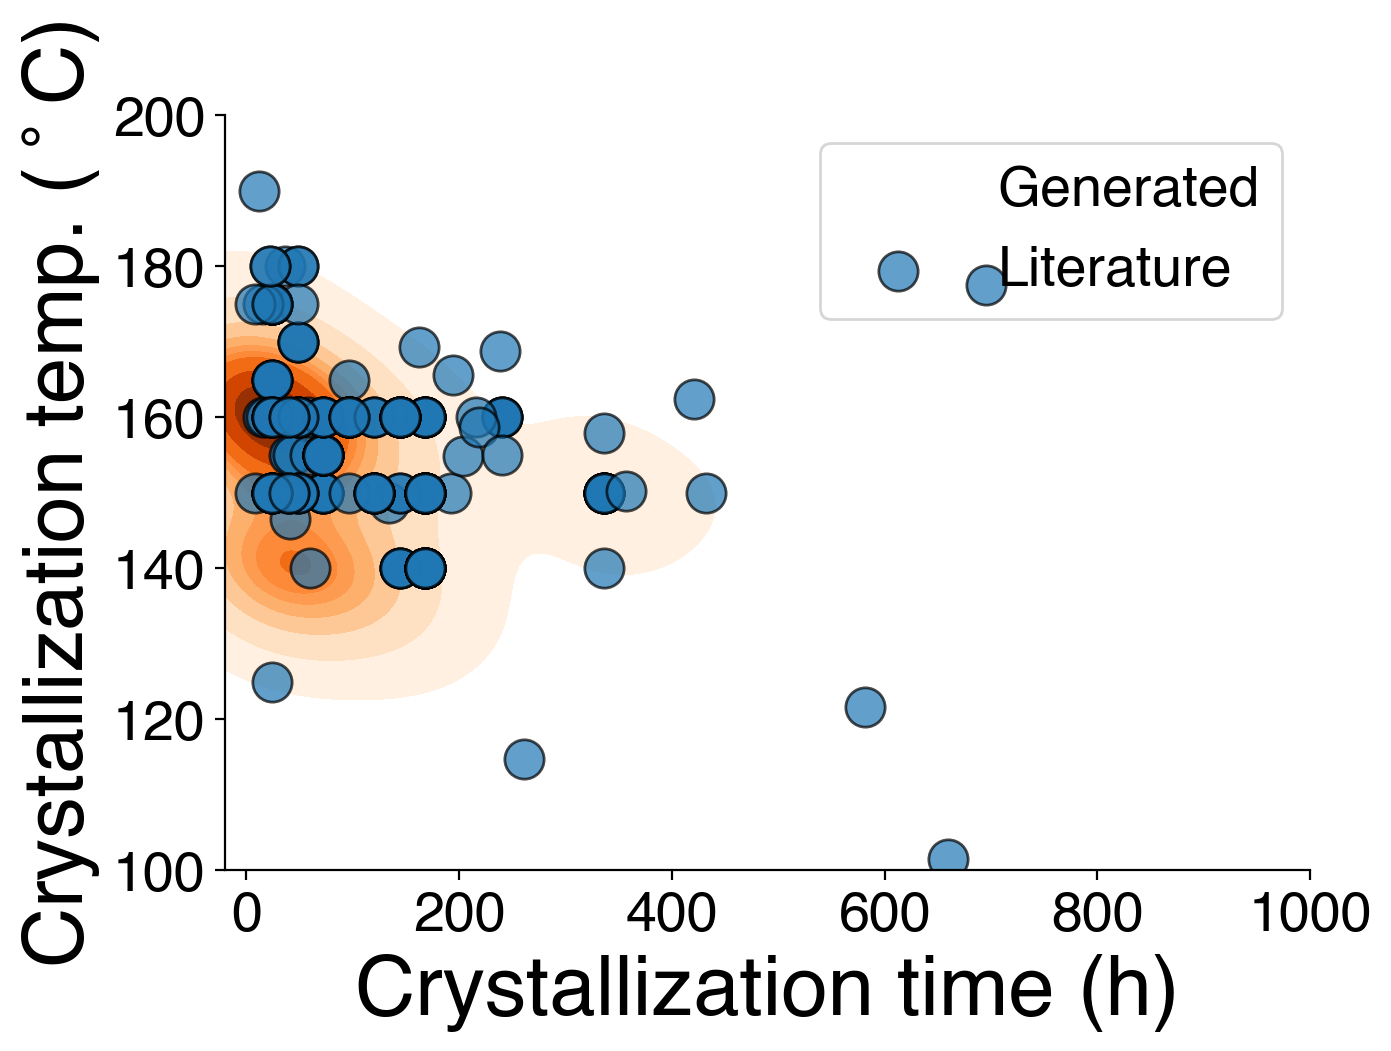

In [12]:
xlim = (-20., 1000)
ylim = (100., 200)

fig = plt.figure(figsize=(7, 5), dpi=200)
sns.kdeplot(data=pred, x='cryst_time', y='cryst_temp', fill=True, cmap='Oranges', alpha=1, label='Generated', bw_adjust=3., clip=(xlim, ylim))
plt.scatter(true['cryst_time'], true['cryst_temp'], color='tab:blue', s=200, alpha=0.7, marker='o', edgecolor='black', label='Literature')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Crystallization time (h)', fontsize=30)
plt.ylabel('Crystallization temp. ($^\circ$C)', fontsize=30)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.legend(loc='upper right', fontsize=20, frameon=True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [13]:
# cost
cost = {'Si': 0.036, 'Al': 0.052, 'NaOH': 0.0087, 'NaCl': 0.0069, 'OSDA': 190}
# NaCl Calculated based on NaOH https://www.sigmaaldrich.com/US/en/product/sial/s1679 and https://www.sigmaaldrich.com/US/en/product/sigald/30620

In [14]:
# sys_syn_pred = syn_pred[(syn_pred['zeo'] == zeo) & (syn_pred['osda'] == osda)]
# sys_syn_pred['Al/Si'] = 1 / sys_syn_pred['Si/Al']
# sys_syn_pred['Al/Si'] = sys_syn_pred['Al/Si'].map(lambda x: 0. if x <= 0.00251 else x)
# sys_syn_pred['Si'] = len(sys_syn_pred) * [1.]
# sys_syn_pred['Al'] = sys_syn_pred['Al/Si'] * sys_syn_pred['Si']
# sys_syn_pred['NaOH'] = sys_syn_pred['OH/T'] * (sys_syn_pred['Si'] + sys_syn_pred['Al'])
# sys_syn_pred['NaCl'] = sys_syn_pred['Na/T'] * (sys_syn_pred['Si'] + sys_syn_pred['Al']) - sys_syn_pred['NaOH']
# sys_syn_pred['NaCl'] = sys_syn_pred['NaCl'].map(lambda x: 0. if x <= 0. else x)
# sys_syn_pred['OSDA'] = sys_syn_pred['sda1/T'] * (sys_syn_pred['Si'] + sys_syn_pred['Al'])
# sys_syn_pred = sys_syn_pred[['Si', 'Al', 'NaOH', 'NaCl', 'OSDA', 'cryst_temp', 'cryst_time']]

# for col in ['Si', 'Al', 'NaOH', 'NaCl', 'OSDA']:
#     sys_syn_pred[col+'_cost'] = sys_syn_pred[col] * cost[col]

# sys_syn_pred['total_cost'] = sys_syn_pred[[x for x in sys_syn_pred.columns if 'cost' in x]].sum(1)
# sys_syn_pred

In [15]:
def preprocess(syn):
    '''Returns preprocessed synthesis (molar fractions) with cost.'''
    sys_syn = syn[(syn['zeo'] == zeo) & (syn['osda'] == osda)]
    sys_syn['Al/Si'] = 1 / sys_syn['Si/Al']
    sys_syn['Al/Si'] = sys_syn['Al/Si'].map(lambda x: 0. if x <= 0.00251 else x)
    sys_syn['Si'] = len(sys_syn) * [1.]
    sys_syn['Al'] = sys_syn['Al/Si'] * sys_syn['Si']
    sys_syn['NaOH'] = sys_syn['OH/T'] * (sys_syn['Si'] + sys_syn['Al'])
    sys_syn['NaCl'] = sys_syn['Na/T'] * (sys_syn['Si'] + sys_syn['Al']) - sys_syn['NaOH']
    sys_syn['NaCl'] = sys_syn['NaCl'].map(lambda x: 0. if x <= 0. else x)
    sys_syn['OSDA'] = sys_syn['sda1/T'] * (sys_syn['Si'] + sys_syn['Al'])
    sys_syn = sys_syn[['Si', 'Al', 'NaOH', 'NaCl', 'OSDA', 'cryst_temp', 'cryst_time']]

    for col in ['Si', 'Al', 'NaOH', 'NaCl', 'OSDA']:
        sys_syn[col+'_cost'] = sys_syn[col] * cost[col]

    sys_syn['total_cost'] = sys_syn[[x for x in sys_syn.columns if 'cost' in x]].sum(1)
    return sys_syn

sys_syn_pred = preprocess(syn_pred)
sys_syn_true = preprocess(syn_true)

/tmp/ipykernel_972563/4244927664.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sys_syn['Al/Si'] = 1 / sys_syn['Si/Al']
/tmp/ipykernel_972563/4244927664.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sys_syn['Al/Si'] = sys_syn['Al/Si'].map(lambda x: 0. if x <= 0.00251 else x)
/tmp/ipykernel_972563/4244927664.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [16]:
sys_syn_pred = sys_syn_pred[sys_syn_pred['cryst_time'] > 0.]

In [17]:
sys_syn_pred

Si        Al      NaOH      NaCl      OSDA  cryst_temp  cryst_time  \
4247    1.0  0.033000  0.157766  0.255434  0.129125       160.0   20.000000   
4248    1.0  0.030067  0.365103  0.000000  0.169565       160.0    8.000000   
4249    1.0  0.025000  0.354580  0.157890  0.152249       140.0   72.000000   
4250    1.0  0.066000  0.639819  0.000000  0.159829       140.0   16.000000   
4251    1.0  0.050000  0.378000  0.104324  0.190909       160.0    8.723031   
...     ...       ...       ...       ...       ...         ...         ...   
257725  1.0  0.066667  0.500043  0.033291  0.110037       140.0   72.000000   
257726  1.0  0.000000  0.197918  0.066555  0.095262       160.0   24.000000   
257727  1.0  0.020000  0.197369  0.143348  0.124930       160.0   72.000000   
257728  1.0  0.025000  0.307500  0.158687  0.201262       160.0   30.681156   
257729  1.0  0.020000  0.204000  0.204000  0.112204       140.0   96.000000   

        Si_cost   Al_cost  NaOH_cost  NaCl_cost  OSDA_cost  total_cost  
4247      0.036  0.001716   0.001373   0.001762  24.533750   24.574601  
4248      0.036  0.001563   0.003176   0.000000  32.217333   32.258073  
4249      0.036  0.001300   0.003085   0.001089  28.927275   28.968749  
4250      0.036  0.003432   0.005566   0.000000  30.367442   30.412440  
4251      0.036  0.002600   0.003289   0.000720  36.272729   36.315337  
...         ...       ...        ...        ...        ...         ...  
257725    0.036  0.003467   0.004350   0.000230  20.907056   20.951103  
257726    0.036  0.000000   0.001722   0.000459  18.099688   18.137869  
257727    0.036  0.001040   0.001717   0.000989  23.736772   23.776518  
257728    0.036  0.001300   0.002675   0.001095  38.239799   38.280870  
257729    0.036  0.001040   0.001775   0.001408  21.318707   21.358930  

[12546 rows x 13 columns]

In [18]:
X = sys_syn_pred[['Si', 'Al', 'NaOH', 'NaCl', 'OSDA', 'cryst_temp', 'cryst_time']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, init='random', perplexity=100)
X_pca = pca.fit_transform(X_scaled)
X_tsne = tsne.fit_transform(X_scaled)
sys_syn_pred['PCA 1'] = X_pca[:, 0]
sys_syn_pred['PCA 2'] = X_pca[:, 1]
sys_syn_pred['t-SNE 1'] = X_tsne[:, 0]
sys_syn_pred['t-SNE 2'] = X_tsne[:, 1]
# sys_syn_pred = sys_syn_pred.sort_values('total_cost', ascending=False)
sys_syn_pred = sys_syn_pred[(sys_syn_pred['Al'] > 0.) & (sys_syn_pred['NaOH'] > 0.) & (sys_syn_pred['OSDA'] > 0.)] # Filter out synthesis with zeros for these parameters
sys_syn_pred = sys_syn_pred[sys_syn_pred['total_cost'] > 0.1] # Filter out synthesis with total cost less than a certain value ##### TBD
sys_syn_pred

/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Si        Al      NaOH      NaCl      OSDA  cryst_temp  cryst_time  \
4247    1.0  0.033000  0.157766  0.255434  0.129125       160.0   20.000000   
4248    1.0  0.030067  0.365103  0.000000  0.169565       160.0    8.000000   
4249    1.0  0.025000  0.354580  0.157890  0.152249       140.0   72.000000   
4250    1.0  0.066000  0.639819  0.000000  0.159829       140.0   16.000000   
4251    1.0  0.050000  0.378000  0.104324  0.190909       160.0    8.723031   
...     ...       ...       ...       ...       ...         ...         ...   
257724  1.0  0.060000  0.689219  0.000000  0.254808       160.0   14.000000   
257725  1.0  0.066667  0.500043  0.033291  0.110037       140.0   72.000000   
257727  1.0  0.020000  0.197369  0.143348  0.124930       160.0   72.000000   
257728  1.0  0.025000  0.307500  0.158687  0.201262       160.0   30.681156   
257729  1.0  0.020000  0.204000  0.204000  0.112204       140.0   96.000000   

        Si_cost   Al_cost  NaOH_cost  NaCl_cost  OSDA_cost  total_cost  \
4247      0.036  0.001716   0.001373   0.001762  24.533750   24.574601   
4248      0.036  0.001563   0.003176   0.000000  32.217333   32.258073   
4249      0.036  0.001300   0.003085   0.001089  28.927275   28.968749   
4250      0.036  0.003432   0.005566   0.000000  30.367442   30.412440   
4251      0.036  0.002600   0.003289   0.000720  36.272729   36.315337   
...         ...       ...        ...        ...        ...         ...   
257724    0.036  0.003120   0.005996   0.000000  48.413461   48.458577   
257725    0.036  0.003467   0.004350   0.000230  20.907056   20.951103   
257727    0.036  0.001040   0.001717   0.000989  23.736772   23.776518   
257728    0.036  0.001300   0.002675   0.001095  38.239799   38.280870   
257729    0.036  0.001040   0.001775   0.001408  21.318707   21.358930   

           PCA 1     PCA 2    t-SNE 1    t-SNE 2  
4247   -1.163262 -0.348638   2.551424 -46.749245  
4248    1.363727 -0.511363 -14.394220  -9.482668  
4249   -0.167331  0.414086   8.045282  31.259264  
4250    2.192123  1.775124 -26.836407  32.773605  
4251    1.159994  0.228249 -34.676830 -24.839951  
...          ...       ...        ...        ...  
257724  3.687829  0.864613 -47.019913  11.936771  
257725  0.814225  1.418068 -23.236425  34.614388  
257727 -0.637749 -0.968211  19.190767 -33.810493  
257728  0.569824 -0.452225  -8.453405 -39.430981  
257729 -1.508469  0.016891  26.648058  31.322538  

[10433 rows x 17 columns]

In [19]:
_X = sys_syn_pred[['Si', 'Al', 'NaOH', 'NaCl', 'OSDA', 'cryst_temp', 'cryst_time']]

kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(_X)
likelihood = kde.score_samples(_X)

sys_syn_pred['likelihood'] = likelihood
sys_syn_pred

Si        Al      NaOH      NaCl      OSDA  cryst_temp  cryst_time  \
4247    1.0  0.033000  0.157766  0.255434  0.129125       160.0   20.000000   
4248    1.0  0.030067  0.365103  0.000000  0.169565       160.0    8.000000   
4249    1.0  0.025000  0.354580  0.157890  0.152249       140.0   72.000000   
4250    1.0  0.066000  0.639819  0.000000  0.159829       140.0   16.000000   
4251    1.0  0.050000  0.378000  0.104324  0.190909       160.0    8.723031   
...     ...       ...       ...       ...       ...         ...         ...   
257724  1.0  0.060000  0.689219  0.000000  0.254808       160.0   14.000000   
257725  1.0  0.066667  0.500043  0.033291  0.110037       140.0   72.000000   
257727  1.0  0.020000  0.197369  0.143348  0.124930       160.0   72.000000   
257728  1.0  0.025000  0.307500  0.158687  0.201262       160.0   30.681156   
257729  1.0  0.020000  0.204000  0.204000  0.112204       140.0   96.000000   

        Si_cost   Al_cost  NaOH_cost  NaCl_cost  OSDA_cost  total_cost  \
4247      0.036  0.001716   0.001373   0.001762  24.533750   24.574601   
4248      0.036  0.001563   0.003176   0.000000  32.217333   32.258073   
4249      0.036  0.001300   0.003085   0.001089  28.927275   28.968749   
4250      0.036  0.003432   0.005566   0.000000  30.367442   30.412440   
4251      0.036  0.002600   0.003289   0.000720  36.272729   36.315337   
...         ...       ...        ...        ...        ...         ...   
257724    0.036  0.003120   0.005996   0.000000  48.413461   48.458577   
257725    0.036  0.003467   0.004350   0.000230  20.907056   20.951103   
257727    0.036  0.001040   0.001717   0.000989  23.736772   23.776518   
257728    0.036  0.001300   0.002675   0.001095  38.239799   38.280870   
257729    0.036  0.001040   0.001775   0.001408  21.318707   21.358930   

           PCA 1     PCA 2    t-SNE 1    t-SNE 2  likelihood  
4247   -1.163262 -0.348638   2.551424 -46.749245   -5.564434  
4248    1.363727 -0.511363 -14.394220  -9.482668   -4.728151  
4249   -0.167331  0.414086   8.045282  31.259264   -4.840287  
4250    2.192123  1.775124 -26.836407  32.773605   -6.349441  
4251    1.159994  0.228249 -34.676830 -24.839951   -5.450171  
...          ...       ...        ...        ...         ...  
257724  3.687829  0.864613 -47.019913  11.936771   -5.669882  
257725  0.814225  1.418068 -23.236425  34.614388   -4.966187  
257727 -0.637749 -0.968211  19.190767 -33.810493   -4.752760  
257728  0.569824 -0.452225  -8.453405 -39.430981   -9.761793  
257729 -1.508469  0.016891  26.648058  31.322538   -4.603748  

[10433 rows x 18 columns]

In [20]:
sys_syn_pred.shape

(10433, 18)

# Precursor cost in reduced dimensions

In [21]:
sys_syn_pred['likelihood'] = 10 ** sys_syn_pred['likelihood']
sys_syn_pred

Si        Al      NaOH      NaCl      OSDA  cryst_temp  cryst_time  \
4247    1.0  0.033000  0.157766  0.255434  0.129125       160.0   20.000000   
4248    1.0  0.030067  0.365103  0.000000  0.169565       160.0    8.000000   
4249    1.0  0.025000  0.354580  0.157890  0.152249       140.0   72.000000   
4250    1.0  0.066000  0.639819  0.000000  0.159829       140.0   16.000000   
4251    1.0  0.050000  0.378000  0.104324  0.190909       160.0    8.723031   
...     ...       ...       ...       ...       ...         ...         ...   
257724  1.0  0.060000  0.689219  0.000000  0.254808       160.0   14.000000   
257725  1.0  0.066667  0.500043  0.033291  0.110037       140.0   72.000000   
257727  1.0  0.020000  0.197369  0.143348  0.124930       160.0   72.000000   
257728  1.0  0.025000  0.307500  0.158687  0.201262       160.0   30.681156   
257729  1.0  0.020000  0.204000  0.204000  0.112204       140.0   96.000000   

        Si_cost   Al_cost  NaOH_cost  NaCl_cost  OSDA_cost  total_cost  \
4247      0.036  0.001716   0.001373   0.001762  24.533750   24.574601   
4248      0.036  0.001563   0.003176   0.000000  32.217333   32.258073   
4249      0.036  0.001300   0.003085   0.001089  28.927275   28.968749   
4250      0.036  0.003432   0.005566   0.000000  30.367442   30.412440   
4251      0.036  0.002600   0.003289   0.000720  36.272729   36.315337   
...         ...       ...        ...        ...        ...         ...   
257724    0.036  0.003120   0.005996   0.000000  48.413461   48.458577   
257725    0.036  0.003467   0.004350   0.000230  20.907056   20.951103   
257727    0.036  0.001040   0.001717   0.000989  23.736772   23.776518   
257728    0.036  0.001300   0.002675   0.001095  38.239799   38.280870   
257729    0.036  0.001040   0.001775   0.001408  21.318707   21.358930   

           PCA 1     PCA 2    t-SNE 1    t-SNE 2    likelihood  
4247   -1.163262 -0.348638   2.551424 -46.749245  2.726255e-06  
4248    1.363727 -0.511363 -14.394220  -9.482668  1.870031e-05  
4249   -0.167331  0.414086   8.045282  31.259264  1.444484e-05  
4250    2.192123  1.775124 -26.836407  32.773605  4.472592e-07  
4251    1.159994  0.228249 -34.676830 -24.839951  3.546734e-06  
...          ...       ...        ...        ...           ...  
257724  3.687829  0.864613 -47.019913  11.936771  2.138542e-06  
257725  0.814225  1.418068 -23.236425  34.614388  1.080969e-05  
257727 -0.637749 -0.968211  19.190767 -33.810493  1.767016e-05  
257728  0.569824 -0.452225  -8.453405 -39.430981  1.730641e-10  
257729 -1.508469  0.016891  26.648058  31.322538  2.490304e-05  

[10433 rows x 18 columns]

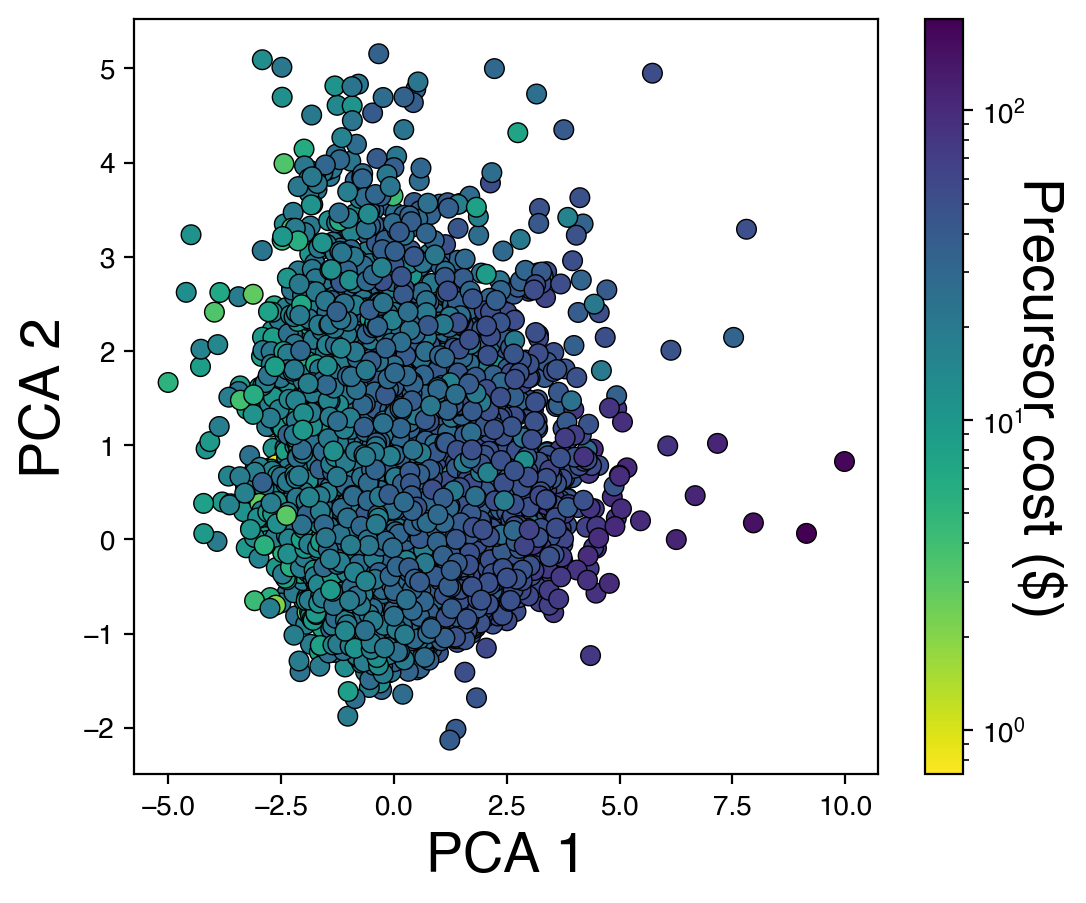

In [22]:
plt.figure(figsize=(6, 5), dpi=200)
plt.scatter(sys_syn_pred['PCA 1'], sys_syn_pred['PCA 2'], marker='o', s=50, linewidth=0.5, c=sys_syn_pred['total_cost'], cmap='viridis_r', edgecolor='black', alpha=1.,
            norm=LogNorm()
            )
cb = plt.colorbar()
cb.set_label('Precursor cost ($)', fontsize=20, rotation=270, labelpad=15)
plt.xlabel('PCA 1', fontsize=20)
plt.ylabel('PCA 2', fontsize=20)
plt.show()

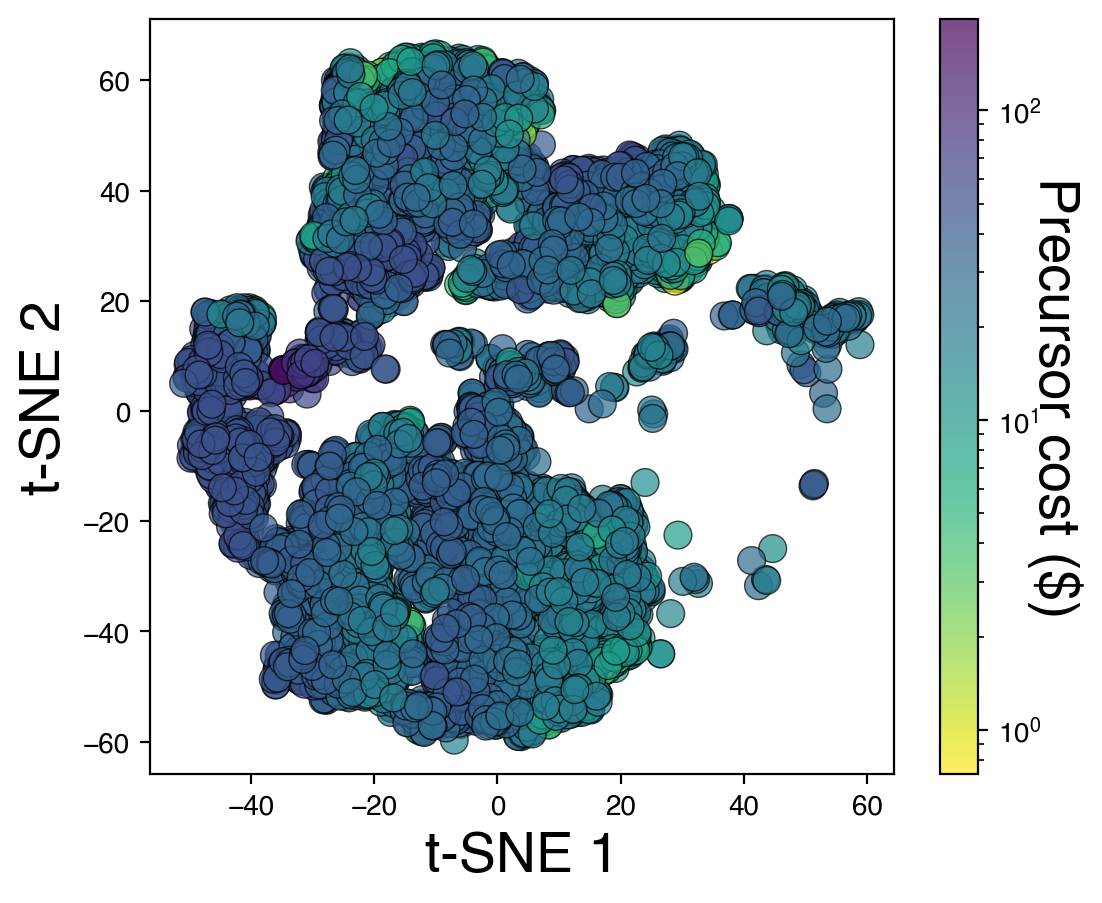

In [23]:
plt.figure(figsize=(6, 5), dpi=200)
plt.scatter(sys_syn_pred['t-SNE 1'], sys_syn_pred['t-SNE 2'], marker='o', s=100, linewidth=0.5, c=sys_syn_pred['total_cost'], cmap='viridis_r', edgecolor='black', alpha=0.7,
            norm=LogNorm()
            )
cb = plt.colorbar()
cb.set_label('Precursor cost ($)', fontsize=20, rotation=270, labelpad=15)
plt.xlabel('t-SNE 1', fontsize=20)
plt.ylabel('t-SNE 2', fontsize=20)
plt.show()

In [24]:
sys_syn_true = sys_syn_true.sort_values('total_cost', ascending=False)
sys_syn_true

Si        Al  NaOH  NaCl  OSDA  cryst_temp  cryst_time  Si_cost  \
4497  1.0       inf   NaN   NaN   NaN  150.000000   40.000000    0.036   
4334  1.0       inf   inf   NaN   inf  160.000000   48.000000    0.036   
4264  1.0       inf   NaN   NaN   NaN  154.939240  203.561295    0.036   
4282  1.0       inf   NaN   NaN   NaN  155.000000   40.000000    0.036   
4313  1.0       inf   NaN   NaN   NaN  140.000000  144.000000    0.036   
...   ...       ...   ...   ...   ...         ...         ...      ...   
4404  1.0  0.011628  0.03  0.07  0.03  155.000000   72.000000    0.036   
4265  1.0  0.083333  0.00  0.00  0.00  150.000000  120.000000    0.036   
4260  1.0  0.000000  0.00  0.00  0.00  148.661530  134.176376    0.036   
4259  1.0  0.000000  0.00  0.00  0.00  168.846237  238.798843    0.036   
4258  1.0  0.000000  0.00  0.00  0.00  121.607887  581.097595    0.036   

       Al_cost  NaOH_cost  NaCl_cost  OSDA_cost  total_cost  
4497       inf        NaN        NaN        NaN         inf  
4334       inf        inf        NaN        inf         inf  
4264       inf        NaN        NaN        NaN         inf  
4282       inf        NaN        NaN        NaN         inf  
4313       inf        NaN        NaN        NaN         inf  
...        ...        ...        ...        ...         ...  
4404  0.000605   0.000261   0.000483   5.699999    5.737347  
4265  0.004333   0.000000   0.000000   0.000000    0.040333  
4260  0.000000   0.000000   0.000000   0.000000    0.036000  
4259  0.000000   0.000000   0.000000   0.000000    0.036000  
4258  0.000000   0.000000   0.000000   0.000000    0.036000  

[251 rows x 13 columns]

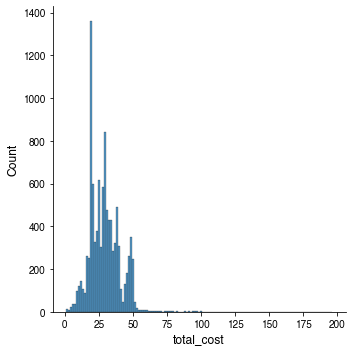

In [25]:
sns.displot(sys_syn_pred['total_cost'])

In [26]:
sys_syn_true['total_cost'].max()

inf

In [27]:
optimal = sys_syn_pred[
               (sys_syn_pred['total_cost'] < 7.5) \
             & (sys_syn_pred['cryst_time'] < 20.) \
             & (sys_syn_pred['likelihood'] > 1e-5) \
             ]
optimal

Si        Al      NaOH      NaCl      OSDA  cryst_temp  cryst_time  \
19913   1.0  0.033333  0.193098  0.151070  0.028642       160.0   12.000000   
24957   1.0  0.028580  0.288092  0.102932  0.029466       160.0   12.000000   
35336   1.0  0.016000  0.235516  0.126609  0.024094       160.0   12.000000   
169870  1.0  0.066667  0.250034  0.118641  0.008446       160.0   12.064363   
216365  1.0  0.036851  0.218417  0.196323  0.029510       160.0   12.000000   
236842  1.0  0.028584  0.303962  0.000000  0.031816       160.0   12.000000   
247284  1.0  0.033333  0.199147  0.099444  0.031911       160.0   12.000000   

        Si_cost   Al_cost  NaOH_cost  NaCl_cost  OSDA_cost  total_cost  \
19913     0.036  0.001733   0.001680   0.001042   5.441919    5.482374   
24957     0.036  0.001486   0.002506   0.000710   5.598537    5.639240   
35336     0.036  0.000832   0.002049   0.000874   4.577939    4.617693   
169870    0.036  0.003467   0.002175   0.000819   1.604689    1.647150   
216365    0.036  0.001916   0.001900   0.001355   5.606964    5.648135   
236842    0.036  0.001486   0.002644   0.000000   6.045098    6.085229   
247284    0.036  0.001733   0.001733   0.000686   6.063136    6.103288   

           PCA 1     PCA 2    t-SNE 1    t-SNE 2  likelihood  
19913  -1.335201 -0.526381  20.365883 -43.731949    0.000048  
24957  -0.652377 -0.562044  22.949673 -42.843575    0.000051  
35336  -1.078786 -0.920909  22.139690 -43.117477    0.000050  
169870 -1.031759  0.312858 -14.406553 -38.148449    0.000049  
216365 -1.402925 -0.296181  19.540985 -44.988113    0.000048  
236842 -0.091248 -0.748463  16.088797 -22.445103    0.000048  
247284 -1.045772 -0.622467  22.443537 -43.452499    0.000049

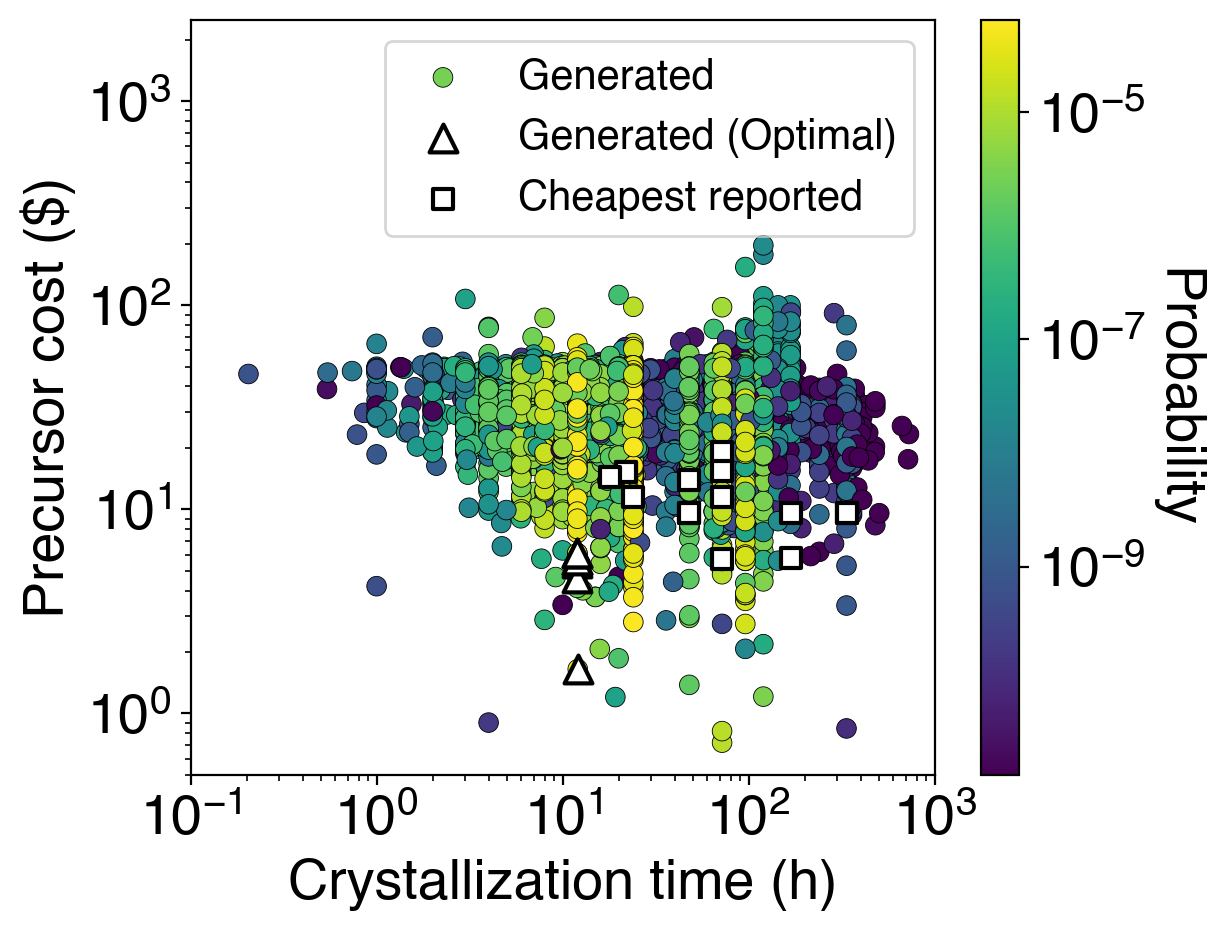

In [28]:
n_lit = 20 # Cheapest n_lit points in literature 

xlim = (0.1, 1e3)
ylim = (0.5, 2.5e3)

fig = plt.figure(figsize=(6, 5), dpi=200)
f = plt.scatter(sys_syn_pred['cryst_time'], sys_syn_pred['total_cost'], marker='o', c=sys_syn_pred['likelihood'], s=50, linewidth=0.3, edgecolor='black', alpha=1., label='Generated', norm=LogNorm())
plt.scatter(optimal['cryst_time'], optimal['total_cost'], marker='^', s=100, linewidth=1.5, c='w', edgecolor='black', alpha=1., label='Generated (Optimal)')
plt.scatter(sys_syn_true['cryst_time'].tail(n_lit), sys_syn_true['total_cost'].tail(n_lit), marker='s', color='w', s=50, linewidth=1.5, edgecolor='black', alpha=1., label='Cheapest reported')
plt.xlabel('Crystallization time (h)', fontsize=20)
plt.ylabel('Precursor cost ($)', fontsize=20)
plt.xscale('log')
plt.yscale('log')

cb = plt.colorbar(f)
cb.set_label('Probability', fontsize=20, rotation=270, labelpad=20)
cb.ax.tick_params(labelsize=20) 

left, width = 0.125, 0.775
bottom, height = 0.125, 0.75
spacing = 0.025
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

plt.xlim(*xlim)
plt.ylim(*ylim)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper right', fontsize=15, frameon=True)

# plt.savefig(f'figs/OPT-CS1/cost-time.pdf', dpi=200, bbox_inches='tight')
plt.show()

In [29]:
_sys_syn_pred = sys_syn_pred[
                            (sys_syn_pred['total_cost'] > 1) & \
                            (sys_syn_pred['cryst_time'] > 0.5)
                            ]

_sys_syn_pred = _sys_syn_pred[
                            ~((sys_syn_pred['total_cost'] < 10) & \
                            (sys_syn_pred['cryst_time'] < 2))
                            ]

/tmp/ipykernel_972563/2574956763.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _sys_syn_pred = _sys_syn_pred[


In [30]:
def find_pareto_points(df):
    # Sort by 'x' then by 'y'
    df = df.sort_values(['cryst_time'])
    
    # Initialize list to store Pareto points
    pareto_points = [df.iloc[0]]
    
    # Iterate through the sorted DataFrame to find Pareto points
    for _, row in df.iterrows():
        if row['total_cost'] < pareto_points[-1]['total_cost']:
            pareto_points.append(row)
    
    # Convert the result to a DataFrame
    pareto_df = pd.DataFrame(pareto_points)

    # Iterate through the sorted DataFrame to find semi-Pareto points
    semipareto_points = []
    for _, row in df.iterrows():
        for _, pareto_row in pareto_df.iterrows():
            if (np.abs(pareto_row['cryst_time'] - row['cryst_time']) < 3) and (np.abs(pareto_row['total_cost'] - row['total_cost']) < 6):
                semipareto_points.append(row)
    semipareto_df = pd.DataFrame(semipareto_points)
    pareto_df = pd.concat([pareto_df, semipareto_df])
    pareto_df = pareto_df.sort_values(['total_cost'], ascending=False)
    
    return pareto_df

sys_syn_pred_pareto = find_pareto_points(_sys_syn_pred)
sys_syn_pred_pareto

Si        Al      NaOH      NaCl      OSDA  cryst_temp  cryst_time  \
45763   1.0  0.033333  0.263881  0.000000  0.234848       160.0    2.000000   
97373   1.0  0.032083  0.290706  0.173179  0.234564       170.0    2.000000   
102513  1.0  0.045700  0.348266  0.013743  0.232031       170.0    2.911069   
242173  1.0  0.100000  0.851613  0.133073  0.220000       140.0    3.000000   
200655  1.0  0.100000  0.323211  0.135980  0.218905       140.0    2.494553   
...     ...       ...       ...       ...       ...         ...         ...   
216274  1.0  0.050000  0.253950  0.114720  0.009581       140.0   20.000000   
169870  1.0  0.066667  0.250034  0.118641  0.008446       160.0   12.064363   
169870  1.0  0.066667  0.250034  0.118641  0.008446       160.0   12.064363   
86960   1.0  0.100000  0.209105  0.137911  0.006095       140.0   19.211708   
86960   1.0  0.100000  0.209105  0.137911  0.006095       140.0   19.211708   

        Si_cost   Al_cost  NaOH_cost  NaCl_cost  OSDA_cost  total_cost  \
45763     0.036  0.001733   0.002296   0.000000  44.621213   44.661242   
97373     0.036  0.001668   0.002529   0.001195  44.567218   44.608611   
102513    0.036  0.002376   0.003030   0.000095  44.085877   44.127378   
242173    0.036  0.005200   0.007409   0.000918  41.800000   41.849527   
200655    0.036  0.005200   0.002812   0.000938  41.592041   41.636991   
...         ...       ...        ...        ...        ...         ...   
216274    0.036  0.002600   0.002209   0.000792   1.820310    1.861911   
169870    0.036  0.003467   0.002175   0.000819   1.604689    1.647150   
169870    0.036  0.003467   0.002175   0.000819   1.604689    1.647150   
86960     0.036  0.005200   0.001819   0.000952   1.158065    1.202036   
86960     0.036  0.005200   0.001819   0.000952   1.158065    1.202036   

           PCA 1     PCA 2    t-SNE 1    t-SNE 2    likelihood  
45763   1.428158 -0.574326 -40.047523 -10.324325  9.568337e-08  
97373   1.009447 -0.644266 -39.480297 -18.486967  1.441170e-09  
102513  2.005687 -0.544978 -30.730686  -9.677615  7.261996e-10  
242173  3.207596  3.354963 -28.223166  27.212406  7.847052e-09  
200655  0.596440  2.352710 -15.294798  46.846966  7.921989e-09  
...          ...       ...        ...        ...           ...  
216274 -1.495420  0.801378   4.054854  50.228249  8.822034e-07  
169870 -1.031759  0.312858 -14.406553 -38.148449  4.854252e-05  
169870 -1.031759  0.312858 -14.406553 -38.148449  4.854252e-05  
86960  -1.777715  1.980371 -18.642725  61.446568  1.004983e-07  
86960  -1.777715  1.980371 -18.642725  61.446568  1.004983e-07  

[599 rows x 18 columns]

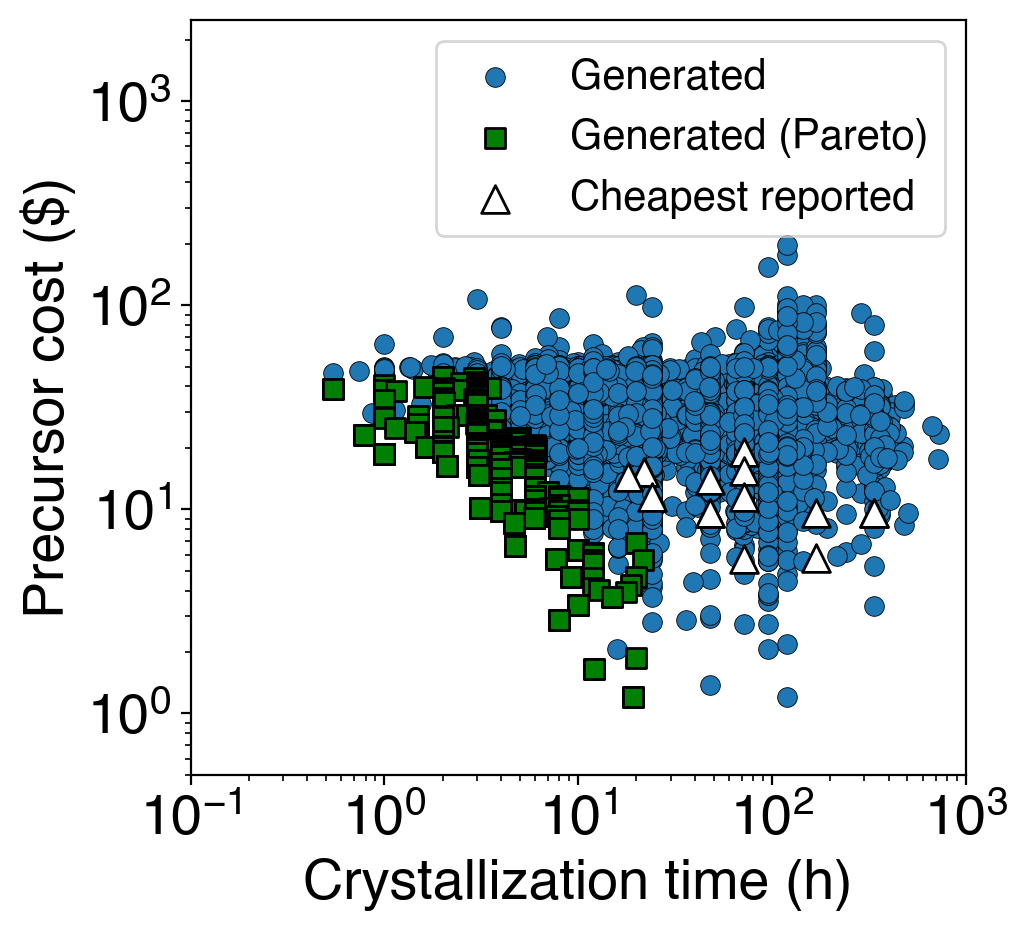

In [31]:
n_lit = 20 # Cheapest n_lit points in literature 

xlim = (0.1, 1e3)
ylim = (0.5, 2.5e3)

fig = plt.figure(figsize=(5, 5), dpi=200)
# f = plt.scatter(sys_syn_pred['cryst_time'], sys_syn_pred['total_cost'], marker='o', c=sys_syn_pred['likelihood'], s=50, linewidth=0.3, edgecolor='black', alpha=1., label='Generated', norm=LogNorm())
f = plt.scatter(_sys_syn_pred['cryst_time'], _sys_syn_pred['total_cost'], marker='o', s=50, linewidth=0.3, edgecolor='black', alpha=1., label='Generated', norm=LogNorm())
plt.scatter(sys_syn_pred_pareto['cryst_time'], sys_syn_pred_pareto['total_cost'], marker='s', color='g', s=50, linewidth=1., edgecolor='black', alpha=1., label='Generated (Pareto)')
plt.scatter(sys_syn_true['cryst_time'].tail(n_lit), sys_syn_true['total_cost'].tail(n_lit), marker='^', color='w', s=100, linewidth=1., edgecolor='black', alpha=1., label='Cheapest reported')
plt.xlabel('Crystallization time (h)', fontsize=20)
plt.ylabel('Precursor cost ($)', fontsize=20)
plt.xscale('log')
plt.yscale('log')

left, width = 0.125, 0.775
bottom, height = 0.125, 0.75
spacing = 0.025
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

plt.xlim(*xlim)
plt.ylim(*ylim)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper right', fontsize=15, frameon=True)

plt.savefig(f'figs/OPT-CS1/cost-time.pdf', dpi=200, bbox_inches='tight')
plt.show()

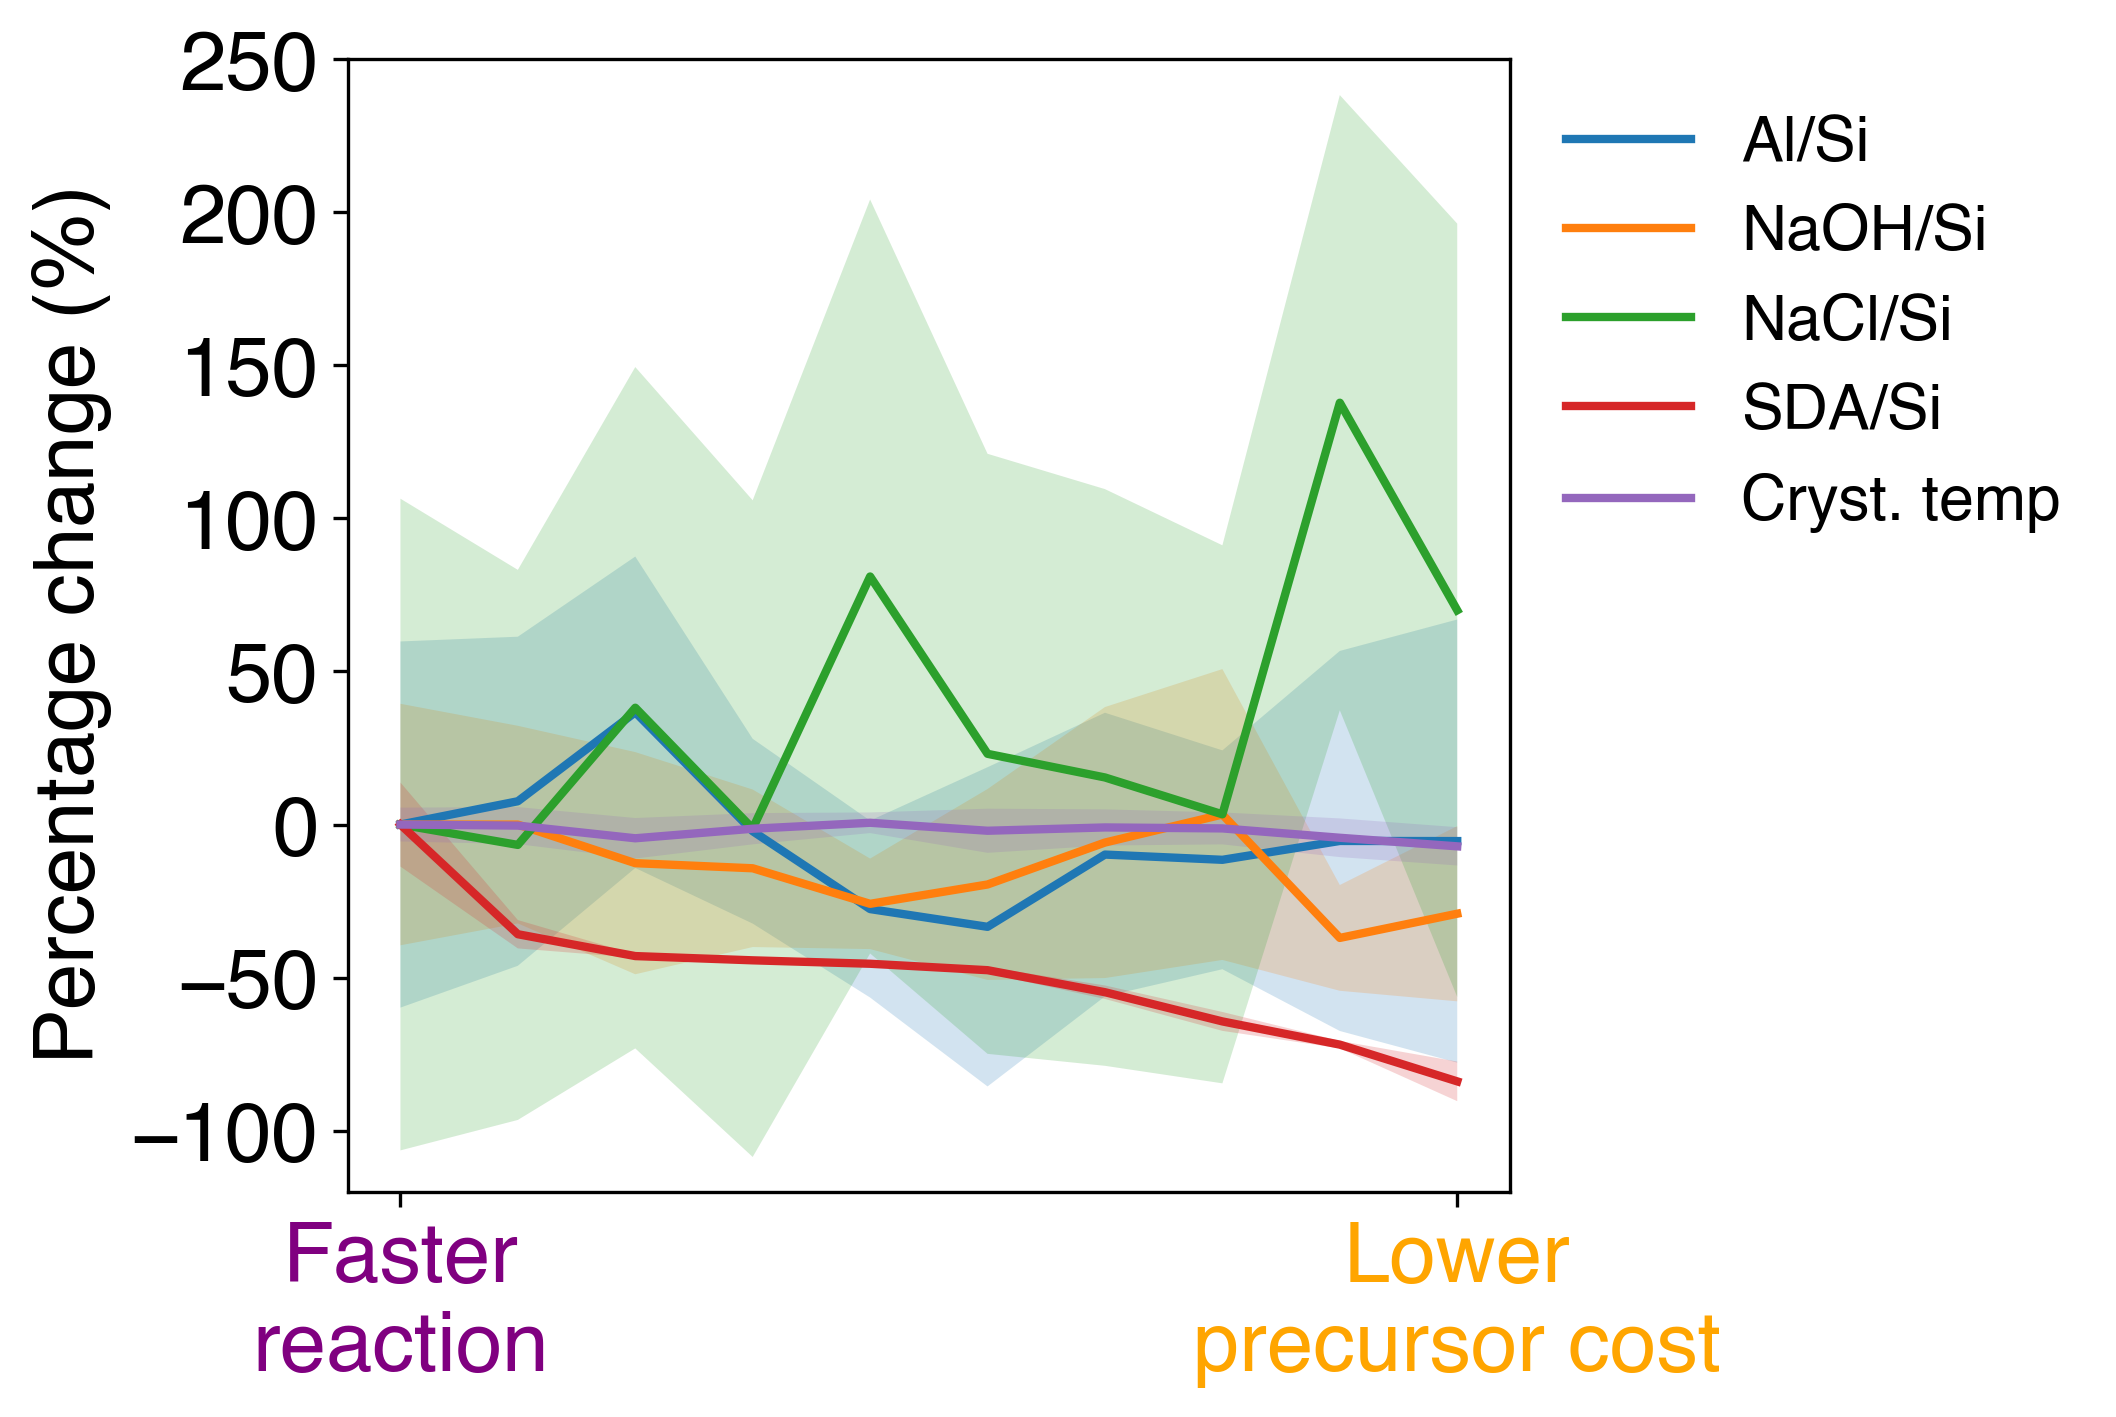

In [32]:
# plot evolution of synthesis parameters across Pareto front

# We first create 10 chunks (deciles) ranked according to the total cost and take the mean and std
n_chunks = 10
chunks = np.array_split(sys_syn_pred_pareto, n_chunks)

plt.figure(figsize=(5, 5), dpi=300)
for col in ['Al', 'NaOH', 'NaCl', 'OSDA', 'cryst_temp']:

    init_mean = chunks[0][col].mean() # initial value

    # # Start at value of 1
    # means_normed = np.array([(c[col]/init_mean).mean() for c in chunks])
    # stds_normed = np.array([(c[col]/init_mean).std() for c in chunks])

    # Start at value 0%
    means_normed = np.array([(100 * c[col]/init_mean - 100).mean() for c in chunks]) # convert to percentages
    stds_normed = np.array([(100 * c[col]/init_mean - 100).std() for c in chunks])

    if col == 'Al':
        col = 'Al/Si'
    elif col == 'NaOH':
        col = 'NaOH/Si'
    elif col == 'NaCl':
        col = 'NaCl/Si'
    elif col == 'OSDA':
        col = 'SDA/Si'
    elif col == 'cryst_temp':
        col = 'Cryst. temp'
    plt.plot(range(n_chunks), means_normed, linewidth=2., label=col)
    plt.fill_between(range(n_chunks), means_normed-stds_normed, means_normed+stds_normed, alpha=0.20)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Percentage change ($\%$)', fontsize=20)

    plt.ylim(-120, 250)

    # Set x-tick labels and apply colors
    plt.xticks([0, n_chunks-1], ['Faster\nreaction', 'Lower\nprecursor cost'], fontsize=20)
    xticks = plt.gca().get_xticklabels()
    for tick, color in zip(xticks, ['purple', 'orange']):
        tick.set_color(color)


plt.legend(fontsize=15)
plt.savefig(f'figs/OPT-CS1/params_over_pareto.pdf', dpi=200, bbox_inches='tight')
plt.show()

In [33]:
sys_syn_pred_pareto

Si        Al      NaOH      NaCl      OSDA  cryst_temp  cryst_time  \
45763   1.0  0.033333  0.263881  0.000000  0.234848       160.0    2.000000   
97373   1.0  0.032083  0.290706  0.173179  0.234564       170.0    2.000000   
102513  1.0  0.045700  0.348266  0.013743  0.232031       170.0    2.911069   
242173  1.0  0.100000  0.851613  0.133073  0.220000       140.0    3.000000   
200655  1.0  0.100000  0.323211  0.135980  0.218905       140.0    2.494553   
...     ...       ...       ...       ...       ...         ...         ...   
216274  1.0  0.050000  0.253950  0.114720  0.009581       140.0   20.000000   
169870  1.0  0.066667  0.250034  0.118641  0.008446       160.0   12.064363   
169870  1.0  0.066667  0.250034  0.118641  0.008446       160.0   12.064363   
86960   1.0  0.100000  0.209105  0.137911  0.006095       140.0   19.211708   
86960   1.0  0.100000  0.209105  0.137911  0.006095       140.0   19.211708   

        Si_cost   Al_cost  NaOH_cost  NaCl_cost  OSDA_cost  total_cost  \
45763     0.036  0.001733   0.002296   0.000000  44.621213   44.661242   
97373     0.036  0.001668   0.002529   0.001195  44.567218   44.608611   
102513    0.036  0.002376   0.003030   0.000095  44.085877   44.127378   
242173    0.036  0.005200   0.007409   0.000918  41.800000   41.849527   
200655    0.036  0.005200   0.002812   0.000938  41.592041   41.636991   
...         ...       ...        ...        ...        ...         ...   
216274    0.036  0.002600   0.002209   0.000792   1.820310    1.861911   
169870    0.036  0.003467   0.002175   0.000819   1.604689    1.647150   
169870    0.036  0.003467   0.002175   0.000819   1.604689    1.647150   
86960     0.036  0.005200   0.001819   0.000952   1.158065    1.202036   
86960     0.036  0.005200   0.001819   0.000952   1.158065    1.202036   

           PCA 1     PCA 2    t-SNE 1    t-SNE 2    likelihood  
45763   1.428158 -0.574326 -40.047523 -10.324325  9.568337e-08  
97373   1.009447 -0.644266 -39.480297 -18.486967  1.441170e-09  
102513  2.005687 -0.544978 -30.730686  -9.677615  7.261996e-10  
242173  3.207596  3.354963 -28.223166  27.212406  7.847052e-09  
200655  0.596440  2.352710 -15.294798  46.846966  7.921989e-09  
...          ...       ...        ...        ...           ...  
216274 -1.495420  0.801378   4.054854  50.228249  8.822034e-07  
169870 -1.031759  0.312858 -14.406553 -38.148449  4.854252e-05  
169870 -1.031759  0.312858 -14.406553 -38.148449  4.854252e-05  
86960  -1.777715  1.980371 -18.642725  61.446568  1.004983e-07  
86960  -1.777715  1.980371 -18.642725  61.446568  1.004983e-07  

[599 rows x 18 columns]

# Cryst. time PCA

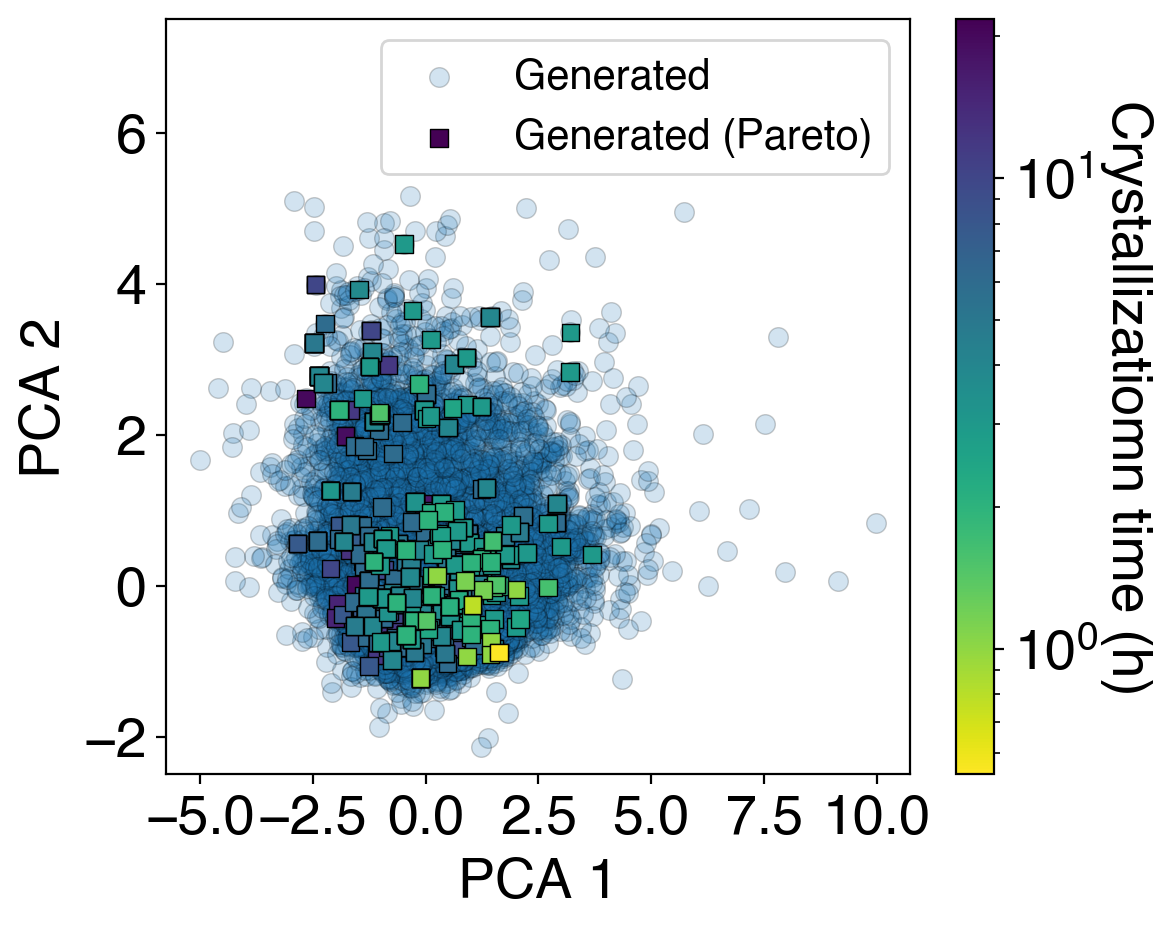

In [34]:
plt.figure(figsize=(6, 5), dpi=200)
plt.scatter(sys_syn_pred.sort_values('total_cost', ascending=False)['PCA 1'], sys_syn_pred.sort_values('total_cost', ascending=False)['PCA 2'], marker='o', s=50, linewidth=0.5, c='tab:blue', edgecolor='black', alpha=0.2, label='Generated')
plt.scatter(sys_syn_pred_pareto.sort_values('cryst_time', ascending=False)['PCA 1'], sys_syn_pred_pareto.sort_values('cryst_time', ascending=False)['PCA 2'], marker='s', s=40, linewidth=0.5, c=sys_syn_pred_pareto.sort_values('cryst_time', ascending=False)['cryst_time'], edgecolor='black', alpha=1, cmap='viridis_r', label='Generated (Pareto)',
            norm=LogNorm(),
            )
cb = plt.colorbar()
cb.set_label('Crystallizatiomn time (h)', fontsize=20, rotation=270, labelpad=20)
cb.ax.tick_params(labelsize=20) 
plt.xlabel('PCA 1', fontsize=20)
plt.ylabel('PCA 2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper right', fontsize=15, frameon=True)
plt.ylim(-2.5, 7.5)
plt.savefig(f'figs/OPT-CS1/cryst_time_pca.pdf', dpi=200, bbox_inches='tight')
plt.show()

# Cost PCA

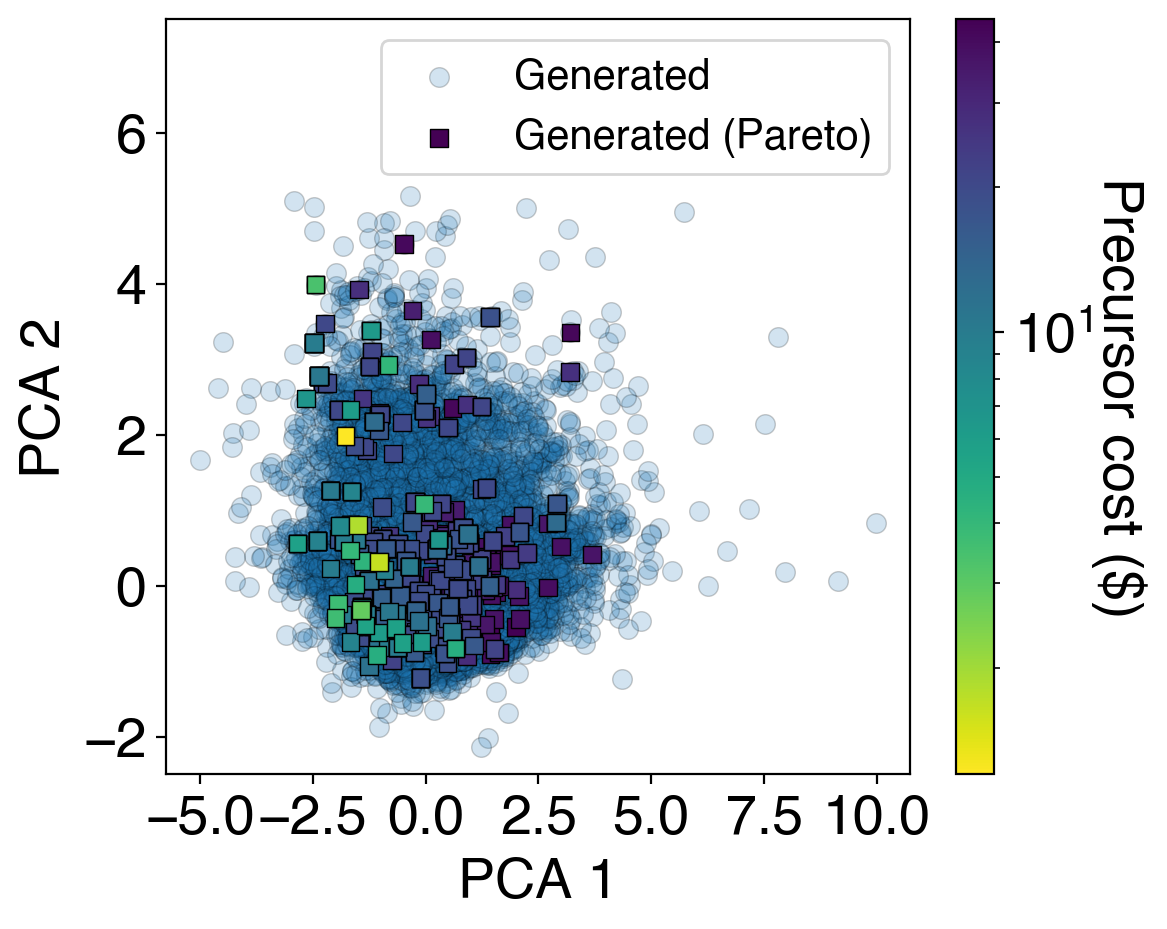

In [35]:
plt.figure(figsize=(6, 5), dpi=200)
plt.scatter(sys_syn_pred.sort_values('total_cost', ascending=False)['PCA 1'], sys_syn_pred.sort_values('total_cost', ascending=False)['PCA 2'], marker='o', s=50, linewidth=0.5, c='tab:blue', edgecolor='black', alpha=0.2, label='Generated')
plt.scatter(sys_syn_pred_pareto.sort_values('total_cost', ascending=False)['PCA 1'], sys_syn_pred_pareto.sort_values('total_cost', ascending=False)['PCA 2'], marker='s', s=40, linewidth=0.5, c=sys_syn_pred_pareto.sort_values('total_cost', ascending=False)['total_cost'], edgecolor='black', alpha=1, cmap='viridis_r', label='Generated (Pareto)',
            norm=LogNorm(),
            )
cb = plt.colorbar()
cb.set_label('Precursor cost ($)', fontsize=20, rotation=270, labelpad=20)
cb.ax.tick_params(labelsize=20) 
plt.xlabel('PCA 1', fontsize=20)
plt.ylabel('PCA 2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper right', fontsize=15, frameon=True)
plt.ylim(-2.5, 7.5)
plt.savefig(f'figs/OPT-CS1/cost_pca.pdf', dpi=200, bbox_inches='tight')
plt.show()

In [36]:
# col2spec = {'Si/Al': {'xlim': (0, 20), 'name': 'Si/Al'},
#             'Ge/Si': {'xlim': (0, 10), 'name': 'Ge/Si'},
#             'B/Si': {'xlim': (0, 10), 'name': 'B/Si'},
#             'Na/Si': {'xlim': (0, 1), 'name': 'Na/Si'},
#             'K/Si': {'xlim': (0, 0.5),  'name': 'K/Si'},
#             'H2O/Si': {'xlim': (0, 100), 'name': 'H$_2$O/Si'},
#             'F/Si': {'xlim': (0, 1), 'name': 'F/Si'},
#             'sda1/Si': {'xlim': (0, 0.75), 'name': 'SDA/Si'},
#             'cryst_temp': {'xlim': (80, 200), 'name': 'Cryst. temp (°C)'},
#             'cryst_time': {'xlim': (0, 1000), 'name': 'Cryst. time (h)'},
#             }

# fig = plt.figure(figsize=(8, 4), dpi=200)

# for i, col in enumerate(col2spec.keys()):
#     ax = fig.add_subplot(2, 5, i+1)
#     plot = sns.histplot(pred[col], color='tab:orange', label='Generated', 
#                  binrange=col2spec[col]['xlim'], bins=25,
#                  stat='density',
#                 #  kde=True, kde_kws={'bw_adjust': 0.5}
#                  )
#     ylim = plot.get_ylim()
#     for v in true[col]:
#         plt.plot([v, v], [0, 0.2 * ylim[-1]], color='tab:blue', linewidth=3, label='Experimental',
#                  alpha=0.5
#                  )
#     plt.xlim(*col2spec[col]['xlim'])
#     plt.xlabel(col2spec[col]['name'])
#     if i % 5 != 0:
#         plt.ylabel('')
#     ax.set_yticklabels([])

# plt.subplots_adjust(wspace=-2, hspace=None)
# plt.tight_layout()
# plt.show()

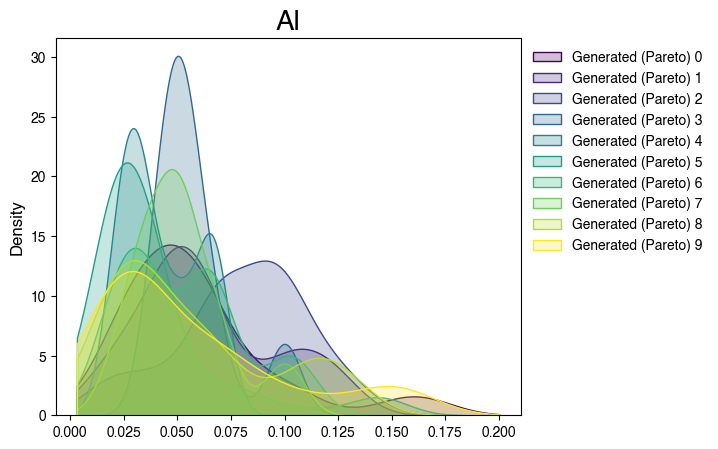

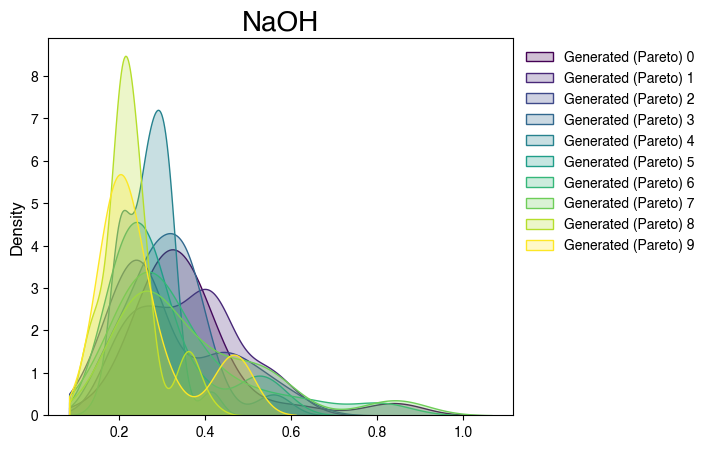

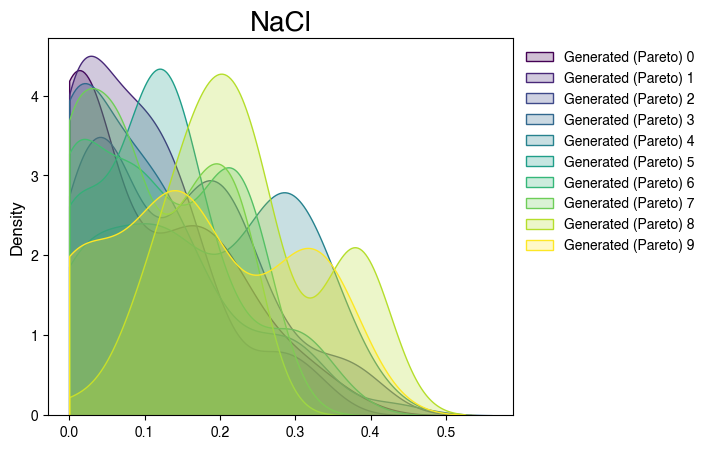

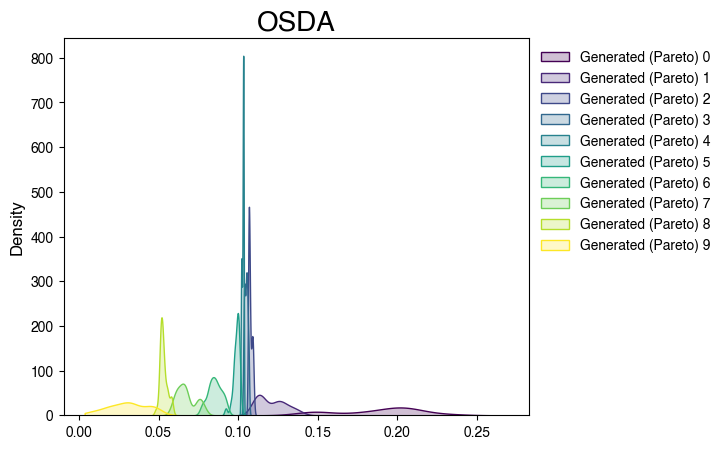

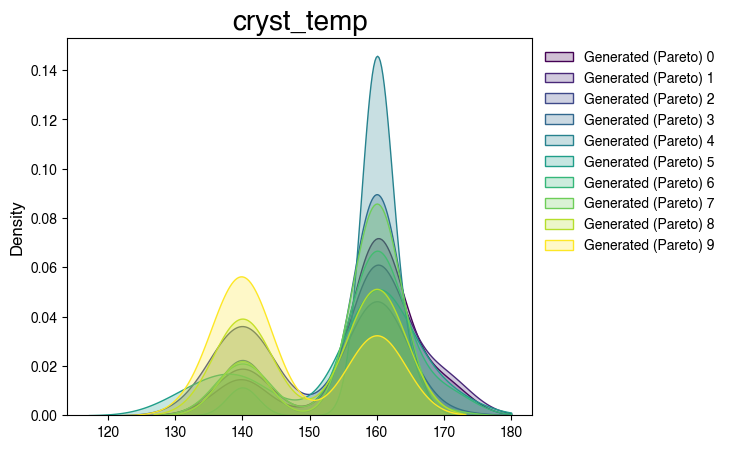

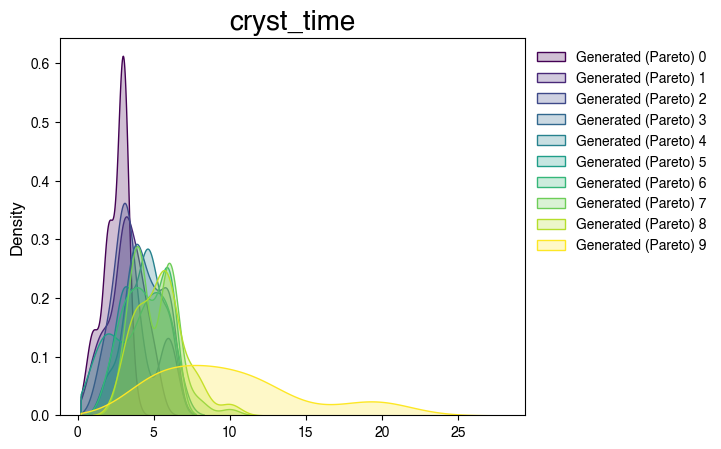

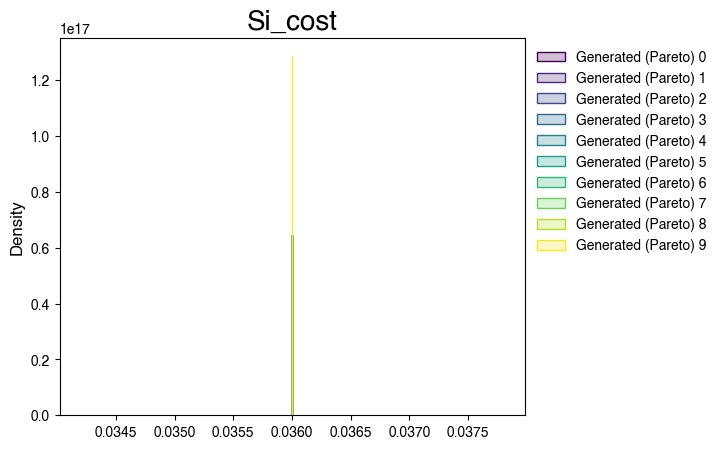

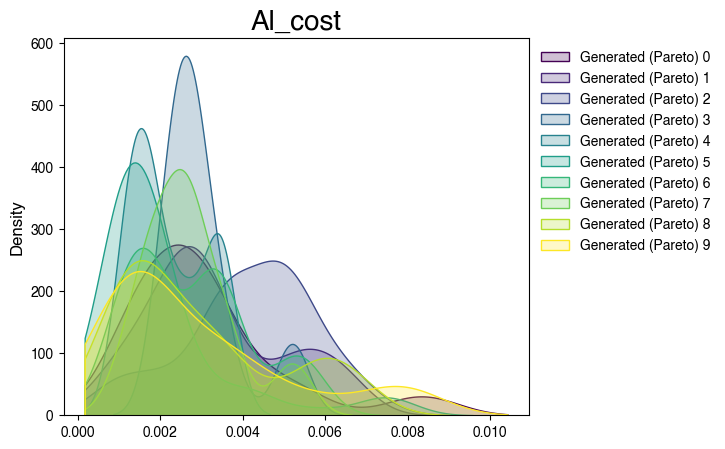

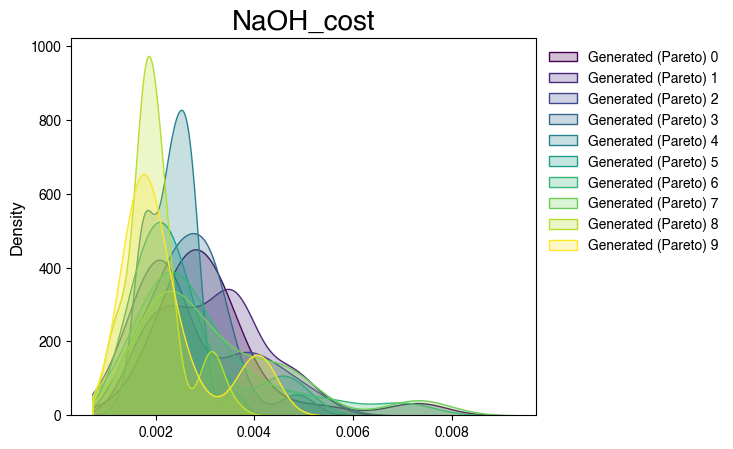

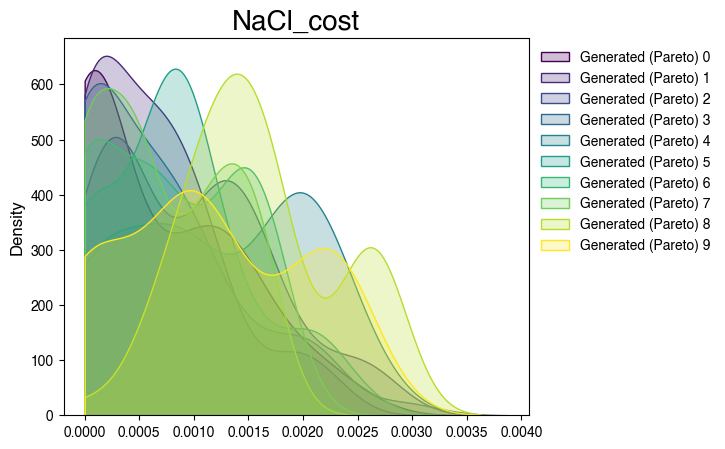

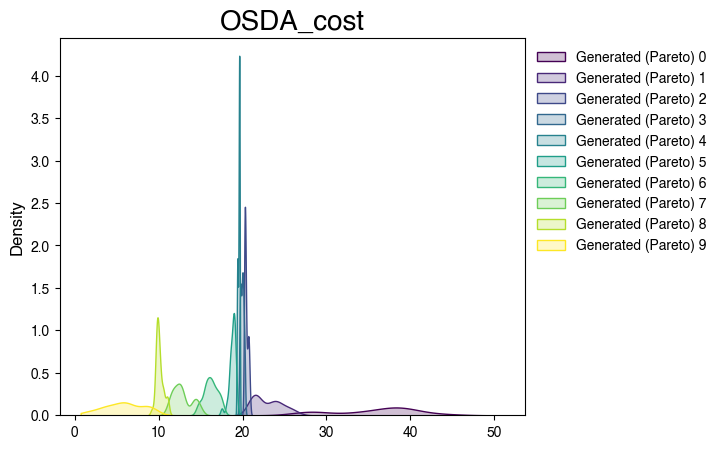

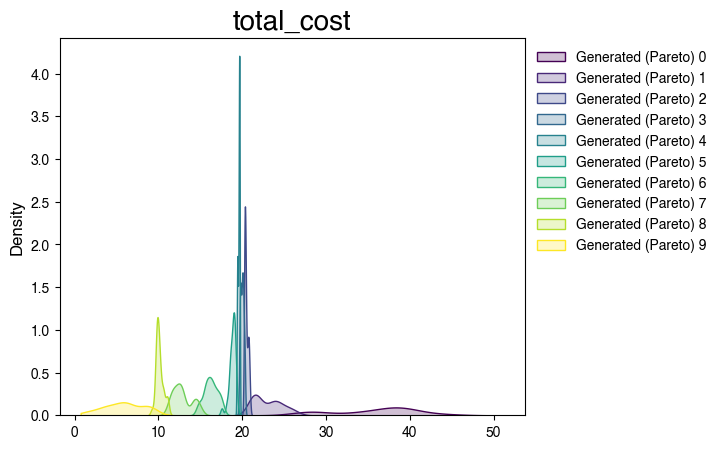

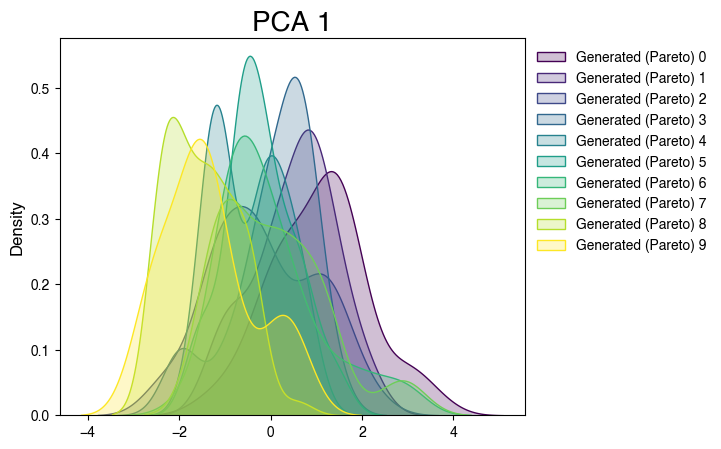

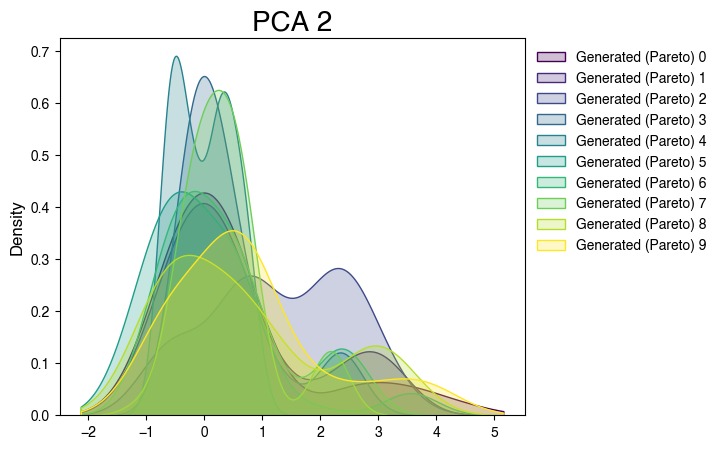

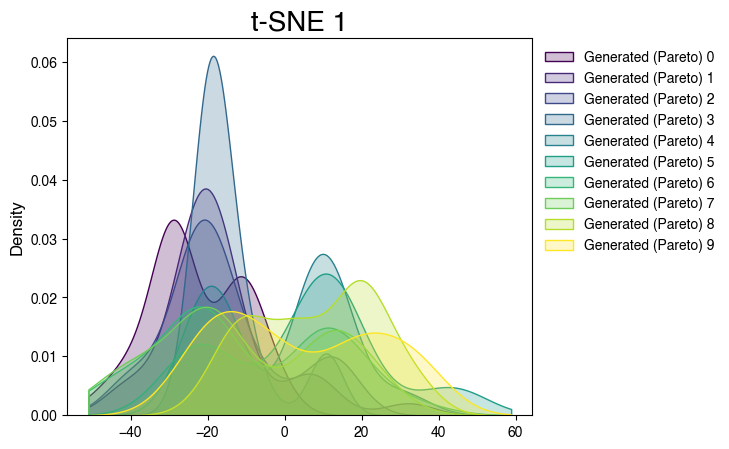

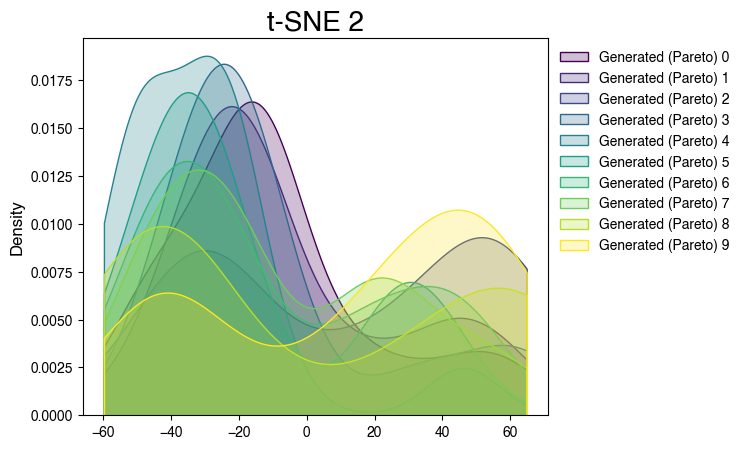

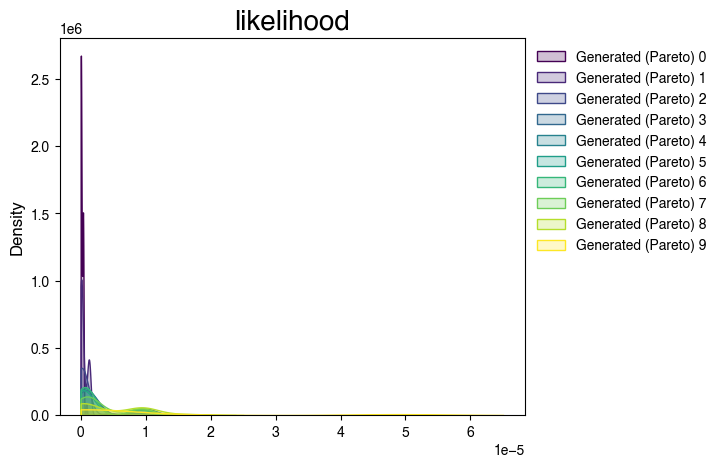

In [37]:
for col in sys_syn_pred.columns[1:]:
    # sns.kdeplot(sys_syn_pred[col], label='Generated', clip=(sys_syn_pred[col].min(), sys_syn_pred[col].max()), color='tab:blue', fill=True)
    
    num_colors = len(chunks)
    cmap = plt.cm.viridis
    colors = [cmap(i / (num_colors - 1)) for i in range(num_colors)]

    plt.figure(figsize=(6, 5), dpi=100)
    for i, (chunk, color) in enumerate(zip(chunks, colors)):
        sns.kdeplot(list(chunk[col]), label=f'Generated (Pareto) {i}', clip=(sys_syn_pred[col].min(), sys_syn_pred[col].max()), color=color, fill=True)

    plt.legend()
    plt.title(col, fontsize=20)
    plt.show()

In [38]:
dfs = []

for col in sys_syn_pred.columns:
    vals = []
    chunk_idxs = []
    for i, chunk in enumerate(chunks):
        vals += list(chunk[col])
        chunk_idxs += [i] * len(chunk)
    dfs.append(pd.DataFrame({col: vals, 'chunk': chunk_idxs}))
     

In [39]:
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap
colors = ['tab:purple', 'orange']
custom_cmap = LinearSegmentedColormap.from_list('custom_purple_orange', colors)

<Figure size 4500x2400 with 0 Axes>

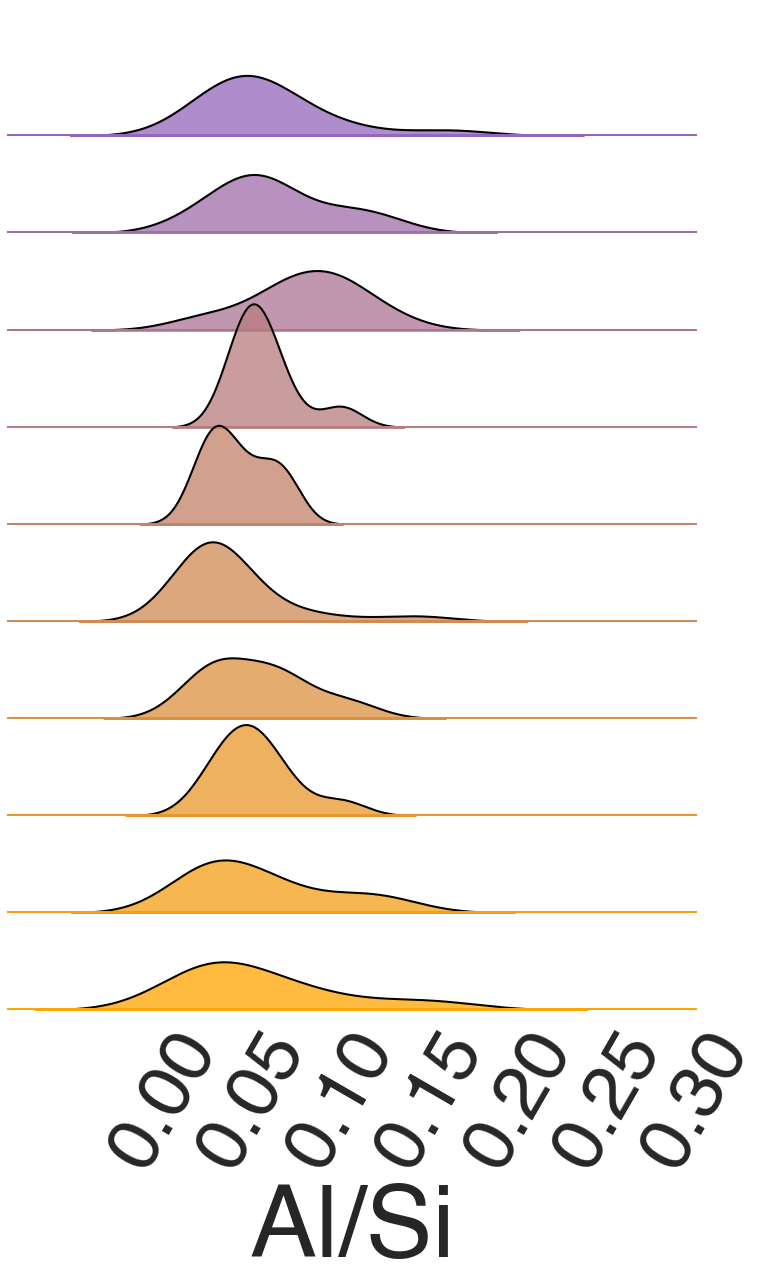

<Figure size 4500x2400 with 0 Axes>

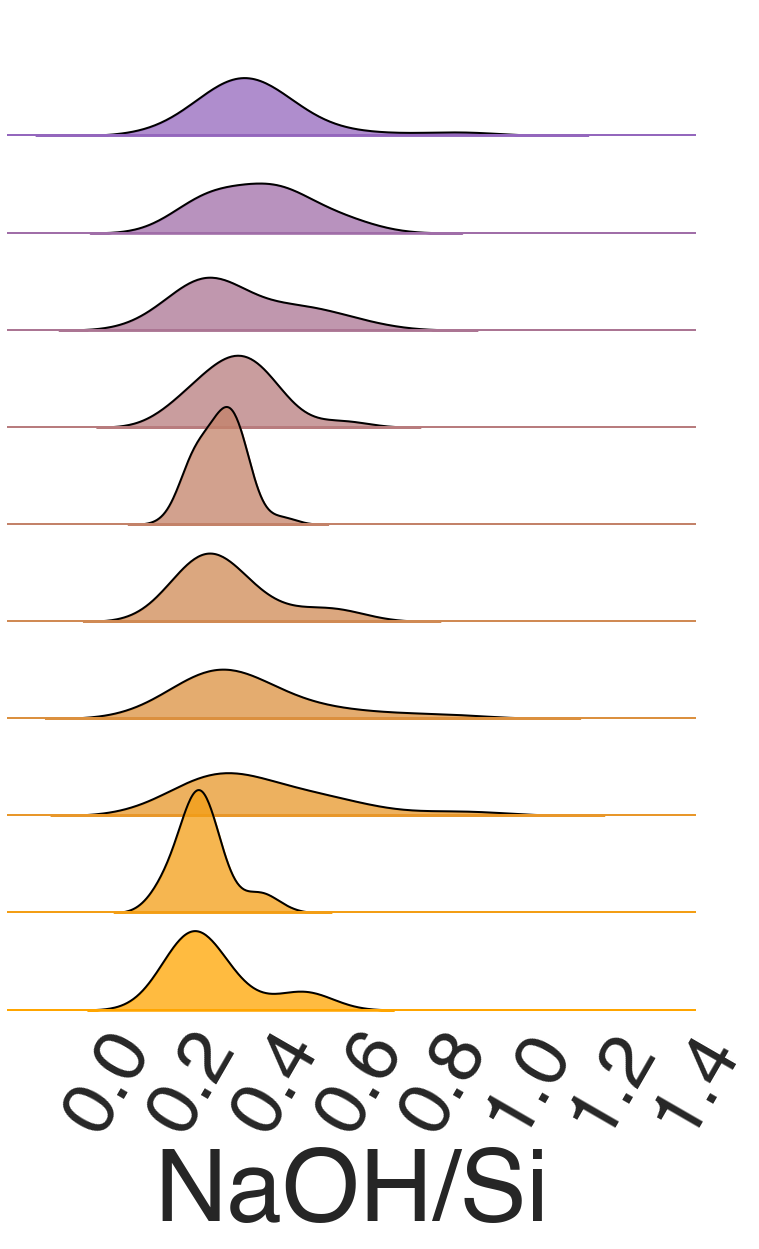

<Figure size 4500x2400 with 0 Axes>

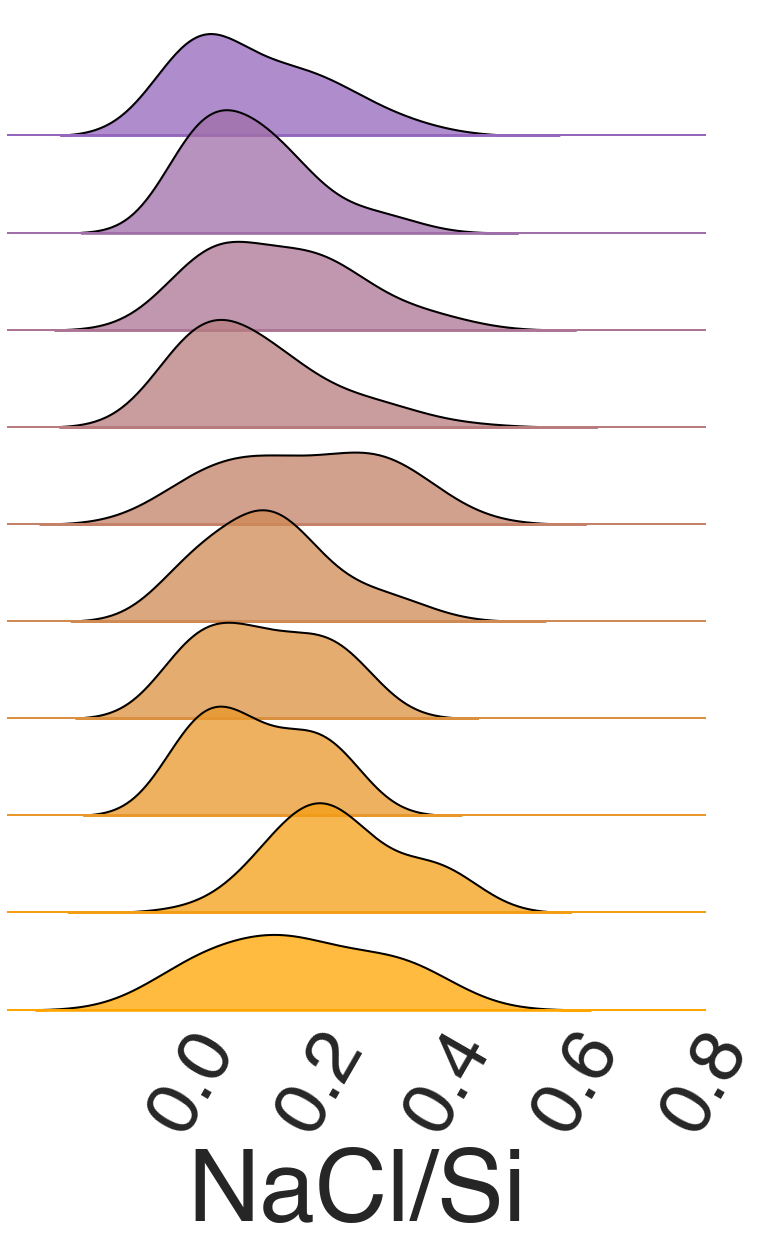

<Figure size 4500x2400 with 0 Axes>

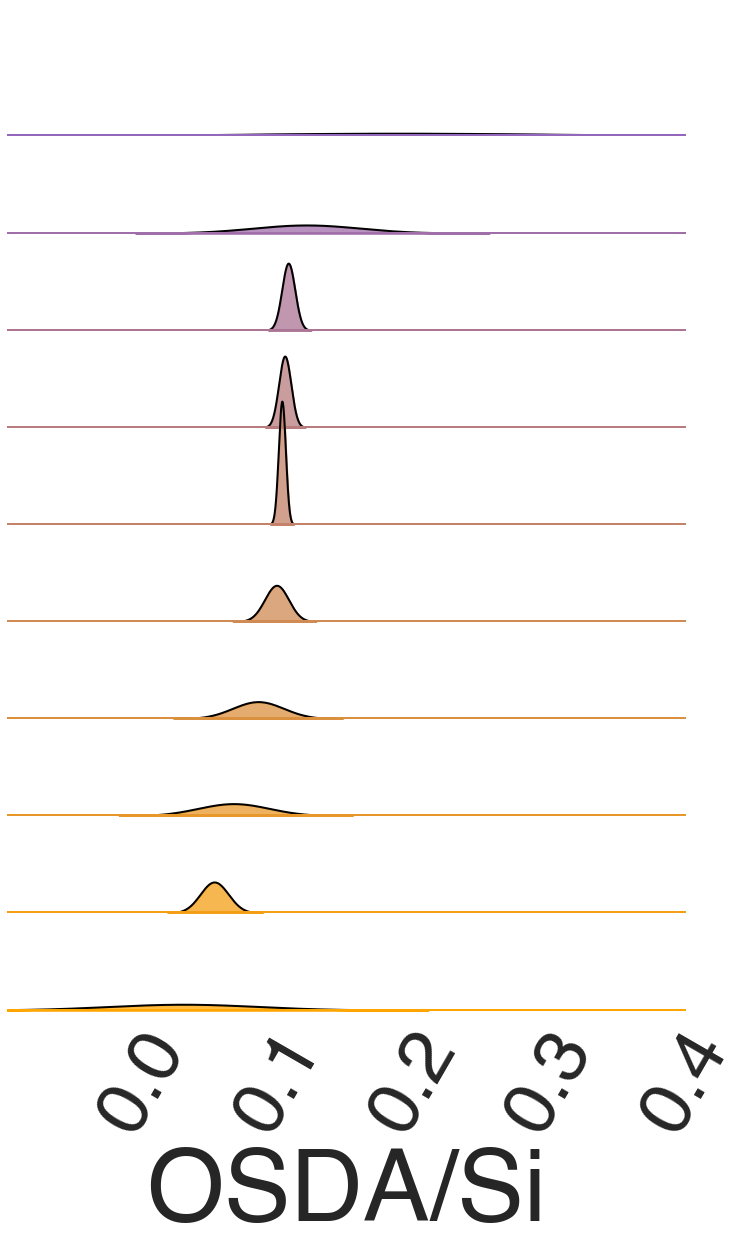

<Figure size 4500x2400 with 0 Axes>

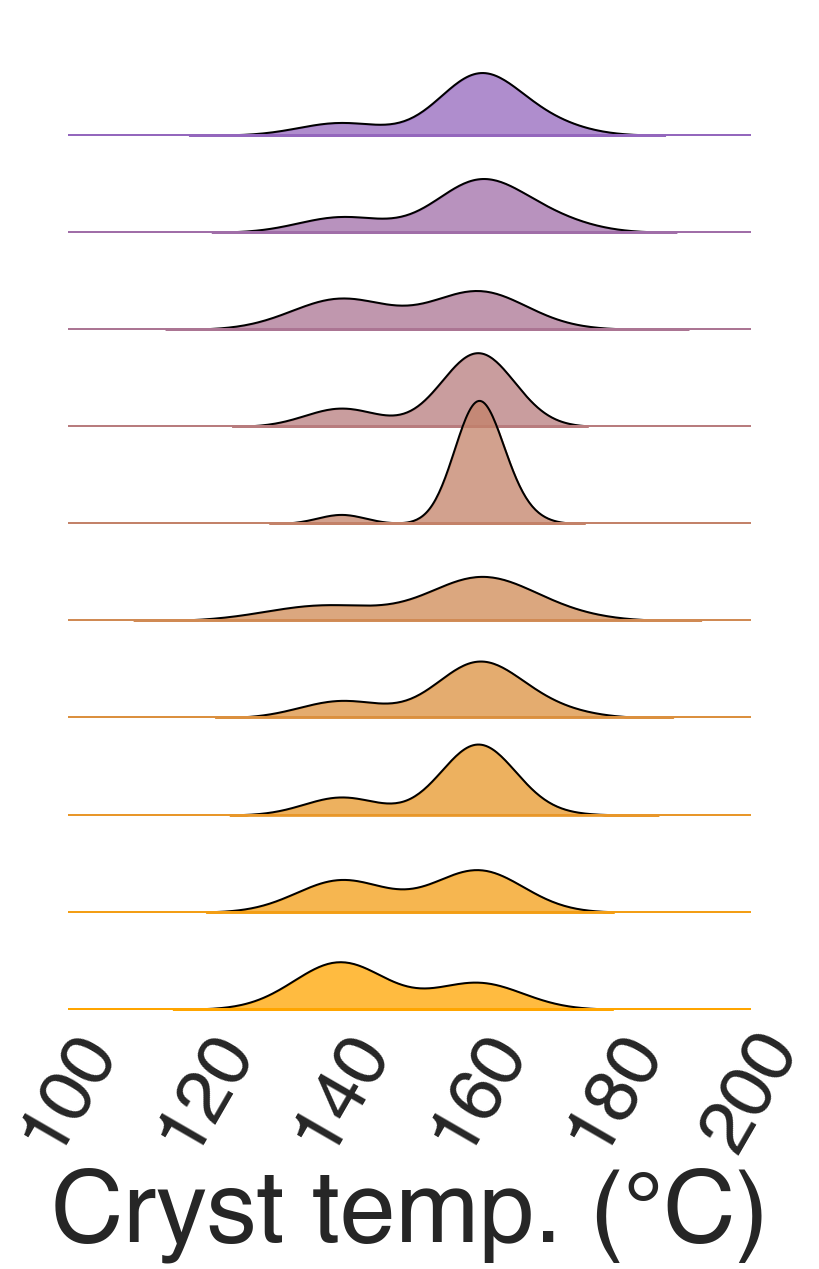

In [58]:

for col, df in zip(sys_syn_pred.columns[1:6], dfs[1:6]): # Skip Si because all 1s
    # sns.kdeplot(sys_syn_pred[col], label='Generated', clip=(sys_syn_pred[col].min(), sys_syn_pred[col].max()), color='tab:blue', fill=True)
    
    plt.figure(figsize=(15, 8), dpi=300)
    num_colors = len(chunks)
    cmap = plt.cm.viridis
    colors = [cmap(i / (num_colors - 1)) for i in range(num_colors)]

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font='Helvetica')

    palette_colors = [custom_cmap(i / (num_colors - 1)) for i in range(num_colors)]
    pal = sns.color_palette(palette_colors)

    # Initialize the FacetGrid object
    # pal = sns.mpl_palette(name='viridis', n_colors=len(chunks))
    g = sns.FacetGrid(df, row="chunk", hue="chunk", aspect=7, height=1.5, palette=pal) # change aspect to adjust figureshape

    # Draw the densities in a few steps
    if col == 'OSDA':
        bw_adjust = 10.
        plt.xlim(-0.1, 0.4)
    else:
        bw_adjust = 1.5
    g.map(sns.kdeplot, col,
        bw_adjust=bw_adjust, clip_on=True,
        fill=True, alpha=0.75, linewidth=1.5,)
    g.map(sns.kdeplot, col, 
        bw_adjust=bw_adjust, clip_on=True, color="black", lw=2,)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=4, linestyle="-", color=None, clip_on=True)

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    if col == 'cryst_temp':
        plt.xlabel('Cryst temp. (°C)', fontsize=100)
    else:
        plt.xlabel(f'{col}/Si', fontsize=100)

    xticks = plt.xticks()[0]  # Get current xtick locations
    non_negative_xticks = [tick for tick in xticks if tick >= 0]  # Keep only non-negative ticks
    plt.xticks(non_negative_xticks, fontsize=75, rotation=60)

    plt.savefig(f'figs/OPT-CS1/{col}_evolution_over_pareto.pdf', dpi=200, bbox_inches='tight')
    plt.show()